In [3]:
import tensorflow as tf
import pathlib
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random 
import seaborn as sns
import matplotlib.gridspec as gridspec # to do the grid of plots
import argparse
import os
import time

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=False, default='./data/img_align_celeba',
#                help="path to input dataset")
#args = vars(ap.parse_args())

# Defining the paths with argparse 
#data_path = args["dataset"] 
data_path = './data/img_align_celeba'
data_dir = pathlib.Path(data_path)

In [4]:
image_count = list(data_dir.glob('*.jpg'))
print(f"Total Images in the folder: {len(image_count)}") # total images

image_count.sort()  # make sure that the filenames have a fixed order before shuffling
random.seed(42) # seed to reprodutibility
random.shuffle(image_count) # shuffles the ordering of filenames (deterministic given the chosen seed)

train_size = 50000  
test_size = 100

#split_1 = int(0.8 * len(image_count))   # geting index 80%
#split_2 = int(0.9 * len(image_count))   # getting index 90% 
train_imgs = image_count[:train_size]      # 80% to train
test_imgs = image_count[train_size+3:train_size+103] # 100 images to test

# Printing total data images in each set 
print(f"Total Train Images in the folder: {len(train_imgs)}") 
#print(f"Total Valid Images in the folder: {len(val_imgs)}") 
print(f"Total Test Images in the folder: {len(test_imgs)}")

Total Images in the folder: 202599
Total Train Images in the folder: 50000
Total Test Images in the folder: 100


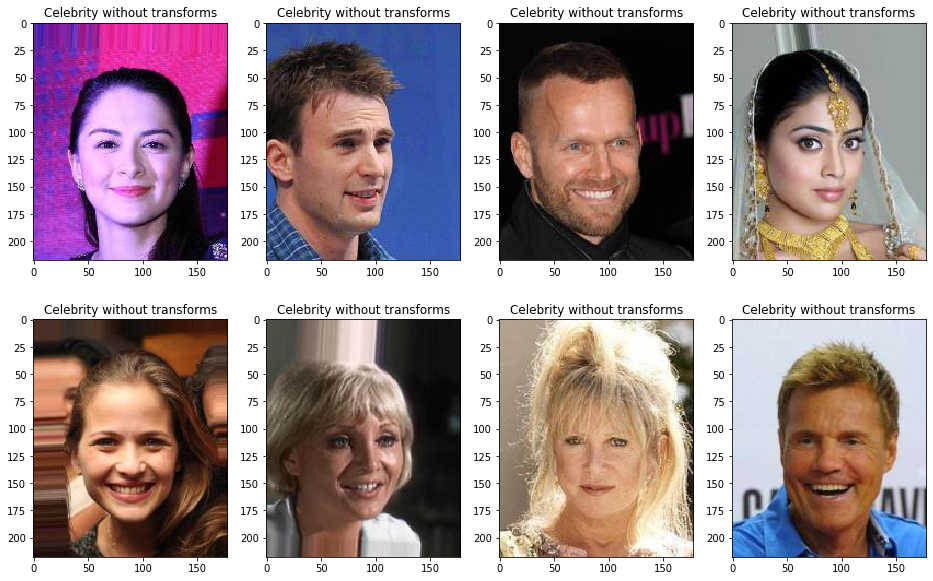

In [5]:
## Ploting a sample of images
grid = gridspec.GridSpec(2, 4) # The grid of chart
plt.figure(figsize=(16,10)) # size of figure

for n, image_path in enumerate(train_imgs[:8]):
    #print(image_path)
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    
    # Reading the one image and seting to figure
    norm_load = Image.open(image_path)
    new_width = 64
    new_height = 64
    #new_img_arr = np.array(Image.fromarray(norm_load).resize((new_width, new_height), Image.ANTIALIAS))
    #Let's plt these images
    img_plot = plt.imshow(norm_load )
    ax.set_title('Celebrity without transforms') 

plt.show()


In [4]:
def crop_center(pil_img, crop_width, crop_height):
    img_width, img_height = pil_img.size
    return pil_img.crop(((img_width - crop_width) // 2,
                         (img_height - crop_height) // 2,
                         (img_width + crop_width) // 2,
                         (img_height + crop_height) // 2))

In [5]:
img_shape = (32, 32, 3)

def get_npdata(nm_imgs_train):
    data = []
    for i, my_img in enumerate(nm_imgs_train):
        # image = Image.open(my_img)
        image = tf.keras.preprocessing.image.load_img(my_img)
        image = crop_center(image, 120, 120)
        image = image.resize(img_shape[:2])
        image = tf.keras.preprocessing.image.img_to_array(image) / 255.00
        data.append(image)
    data = np.array(data)
    return(data)


In [6]:
X_train = get_npdata(train_imgs)
print("X_train.shape = {}".format(X_train.shape))

X_test  = get_npdata(test_imgs)
print("X_test.shape = {}".format(X_test.shape))

X_train.shape = (100000, 32, 32, 3)
X_test.shape = (100, 32, 32, 3)


# Images after crop and resizing

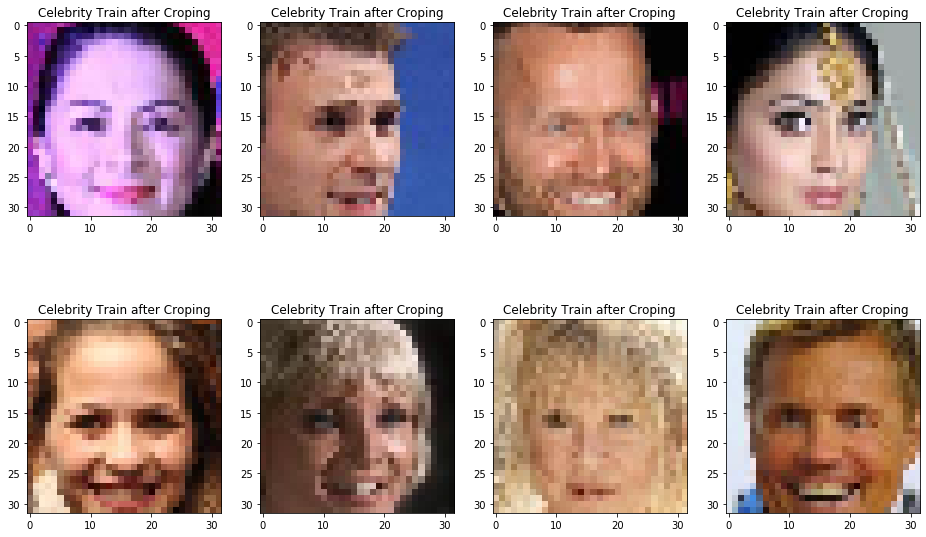

In [7]:
## Ploting a sample of images
grid = gridspec.GridSpec(2, 4) # The grid of chart
plt.figure(figsize=(16,10)) # size of figure

for n, image_path in enumerate(X_train[:8]):
    #print(image_path)
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    # Reading the one image and seting to figure
    #norm_load = Image.open(image_path)
    new_width = 64
    new_height = 64
    #new_img_arr = np.array(Image.fromarray(norm_load).resize((new_width, new_height), Image.ANTIALIAS))
    #Let's plt these images
    img_plot = plt.imshow(tf.keras.preprocessing.image.array_to_img(image_path))
    ax.set_title('Celebrity Train after Croping') 

plt.show()


It's a very pixeled data but keep the face details that the model will try to generate

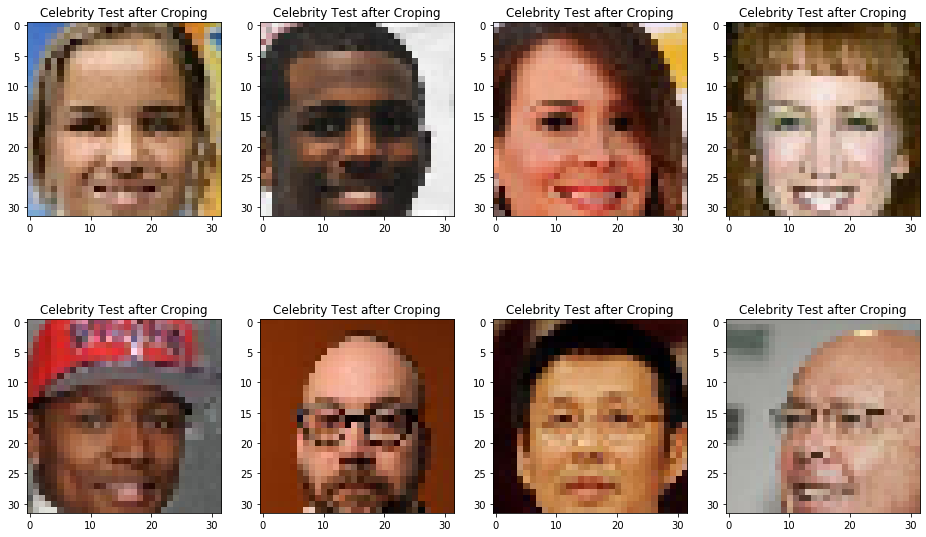

In [8]:
## Ploting a sample of images
grid = gridspec.GridSpec(2, 4) # The grid of chart
plt.figure(figsize=(16,10)) # size of figure

for n, image_path in enumerate(X_test[:8]):
    #print(image_path)
    ax = plt.subplot(grid[n]) # feeding the figure of grid
    # Reading the one image and seting to figure
    #norm_load = Image.open(image_path)
    new_width = 64
    new_height = 64
    #new_img_arr = np.array(Image.fromarray(norm_load).resize((new_width, new_height), Image.ANTIALIAS))
    #Let's plt these images
    img_plot = plt.imshow(tf.keras.preprocessing.image.array_to_img(image_path))
    ax.set_title('Celebrity Test after Croping') 

plt.show()


# Defining the Generator

In [9]:
from tensorflow.keras import backend

# implementation of wasserstein loss
def wasserstein_loss(y_true, y_pred):
    return backend.mean(y_true * y_pred)


In [15]:
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import RandomNormal
## optimizer
#optimizer = Adam(0.0002, 0.5)
g_optimizer = Adam(0.00008, 0.5)
d_optimizer = Adam(0.0001, 0.5)

#weights_initializer = RandomNormal(mean=0., stddev=0.01)
weights_initializer = tf.keras.initializers.GlorotNormal()
def build_generator(img_shape, noise_shape = (100,)):
    '''
    noise_shape : the dimension of the input vector for the generator
    img_shape   : the dimension of the output
    '''
    
    ## latent variable as input
    input_noise = layers.Input(shape=noise_shape) 
    d = layers.Dense(1024, activation="relu", kernel_initializer=weights_initializer)(input_noise) 
    #d = layers.Dense(256, activation="relu")(d) 
    d = layers.Dense(128*8*8, activation="relu", kernel_initializer=weights_initializer)(d)
    d = layers.Reshape((8,8,128))(d) # 8x8
    
    d = layers.Conv2DTranspose(128, kernel_size=(2,2) , 
                               strides=(2,2) , use_bias=False)(d) # 16x16

    d = layers.Conv2DTranspose(32, kernel_size=(2,2) , 
                               strides=(2,2) , use_bias=False)(d) # 32x32

    if img_shape[0] == 64:
        d = layers.Conv2DTranspose(32, kernel_size=(2,2) ,  
                                   strides=(2,2) , use_bias=False)(d) #64x64
    
    img = layers.Conv2D( 3 , ( 1 , 1 ), kernel_initializer=weights_initializer, activation='sigmoid' , 
                        padding='same', name="final_block")(d) ## keep the size
    
    model = models.Model(input_noise, img)
    model.summary() 
    
    return(model)

## Set the dimension of latent variables to be 100
noise_shape = (150,)

generator = build_generator(img_shape, noise_shape = noise_shape)

generator.compile(loss='binary_crossentropy', optimizer=g_optimizer)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              154624    
_________________________________________________________________
dense_3 (Dense)              (None, 8192)              8396800   
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 16, 16, 128)       65536     
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 32)        16384     
_________________________________________________________________
final_block (Conv2D)         (None, 32, 32, 3)         99  

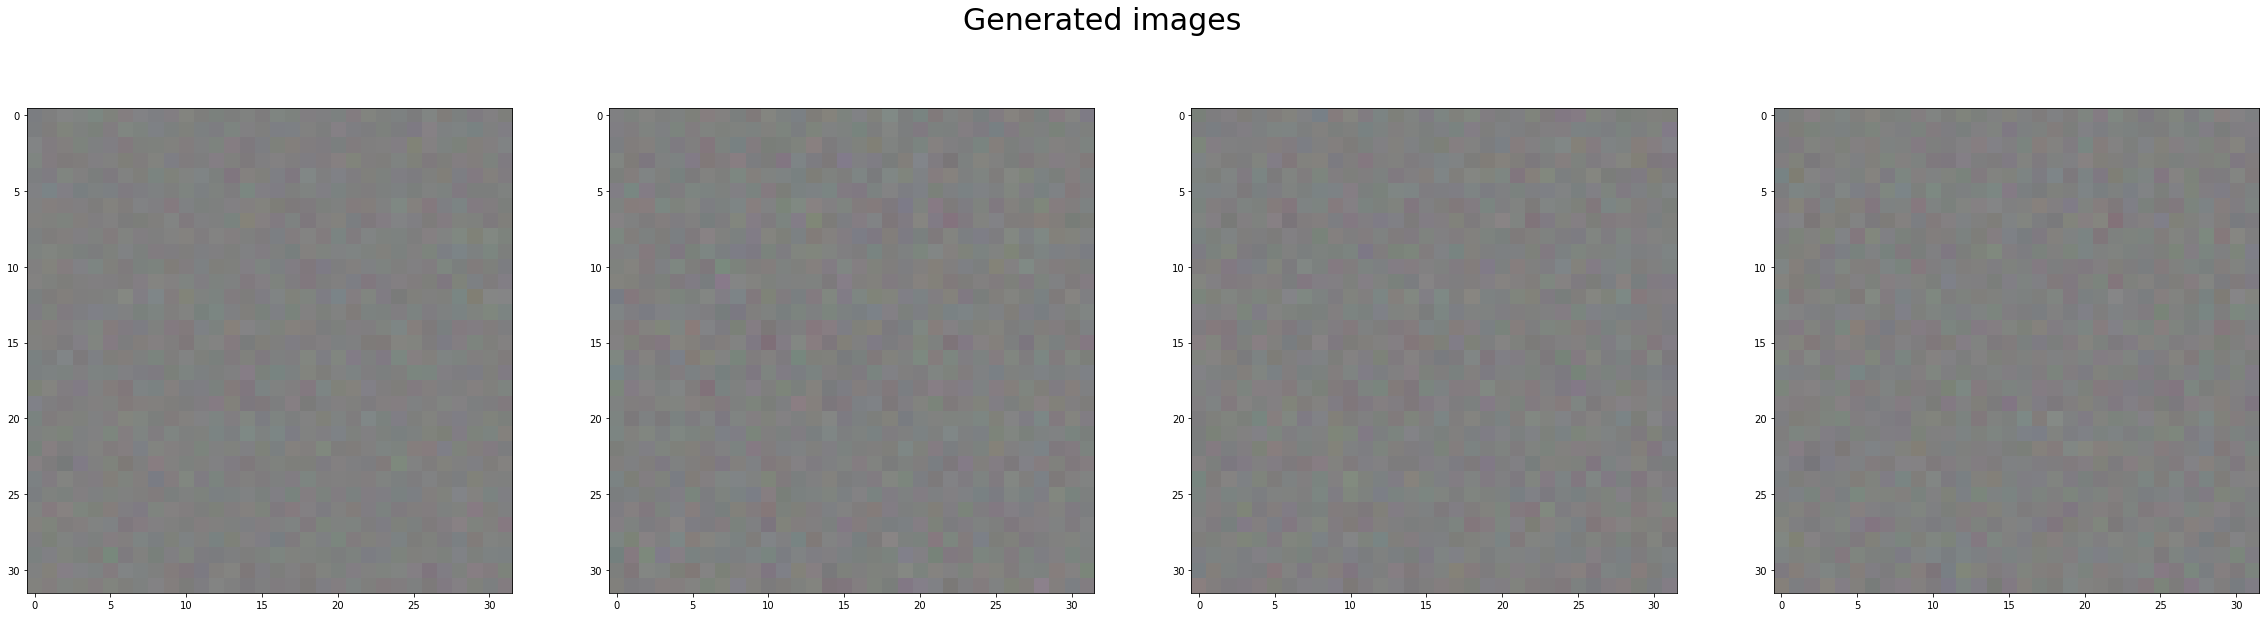

In [16]:
def get_noise(nsample=1, nlatent_dim=100):
    noise = np.random.normal(0, 1, (nsample,nlatent_dim))
    return(noise)

def plot_generated_images(noise,path_save=None,titleadd=""):
    imgs = generator.predict(noise)
    fig = plt.figure(figsize=(40,10))
    for i, img in enumerate(imgs):
        ax = fig.add_subplot(1,nsample,i+1)
        ax.imshow(img)
    fig.suptitle("Generated images "+titleadd,fontsize=30)
    
    if path_save is not None:
        plt.savefig(path_save,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.close()
    else:
        plt.show()

nsample = 4
noise = get_noise(nsample=nsample, nlatent_dim=noise_shape[0])
plot_generated_images(noise)

In [17]:
def build_discriminator(img_shape,noutput=1):
    input_img = layers.Input(shape=img_shape)
    
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name='block1_conv1')(input_img)
    x = layers.Conv2D(32, (5, 5), activation='relu', padding='same', name='block1_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)
    
    x = layers.Conv2D(64, (5,5), activation='relu', padding='same', name='block2_conv1')(x)
    x = layers.Conv2D(64, (5, 5), activation='relu', padding='same', name='block2_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)
    
    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same', name='block4_conv1')(x)
    x = layers.Conv2D(128, (2, 2), activation='relu', padding='same', name='block4_conv2')(x)
    x = layers.MaxPooling2D((2, 2), strides=(1, 1), name='block4_pool')(x)

    
    x         = layers.Flatten()(x)
    x         = layers.Dense(1024,      activation="relu")(x)
    out       = layers.Dense(noutput,   activation='sigmoid')(x)
    model     = models.Model(input_img, out)
    
    return model


discriminator  = build_discriminator(img_shape)

discriminator.compile(loss='binary_crossentropy', 
                      optimizer=d_optimizer, metrics=['accuracy'])

discriminator.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        2432      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        25632     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 64)        51264     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 64)        102464    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 64)          0   

In [18]:
z = layers.Input(shape=noise_shape)
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The valid takes generated images as input and determines validity
valid = discriminator(img)

# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity 

combined = models.Model(z, valid)

combined.compile(loss='binary_crossentropy', optimizer=d_optimizer)
combined.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
model_1 (Model)              (None, 32, 32, 3)         8633443   
_________________________________________________________________
model_2 (Model)              (None, 1)                 6704929   
Total params: 15,338,372
Trainable params: 8,633,443
Non-trainable params: 6,704,929
_________________________________________________________________


Epoch 00000 [D loss: 0.728, acc.: 046.9%] [G loss: 0.655]


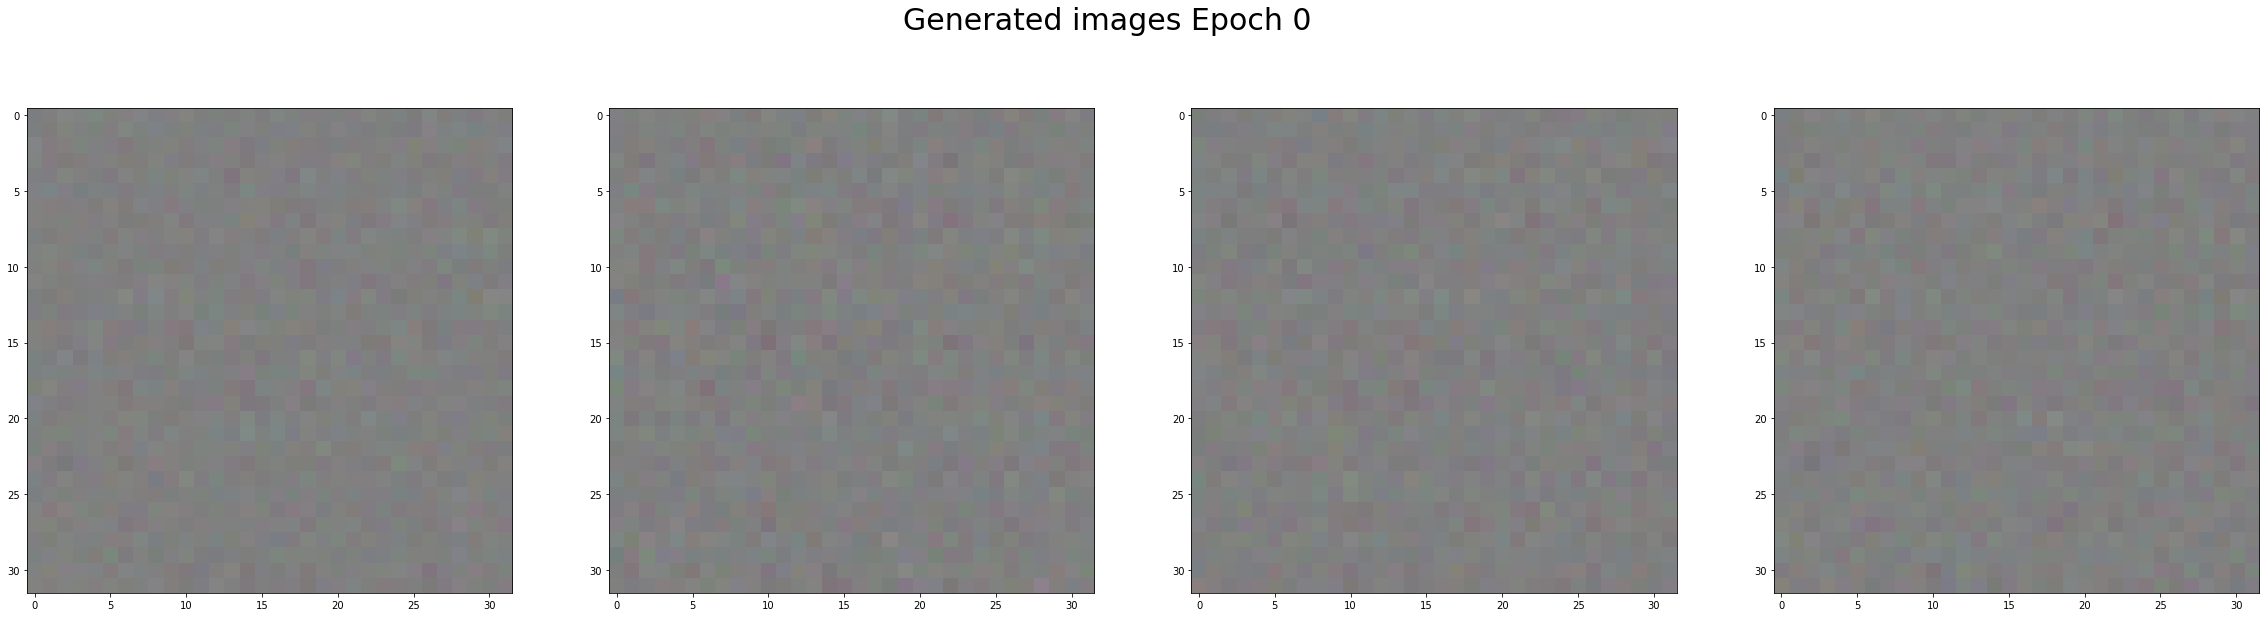

Epoch 00500 [D loss: 0.349, acc.: 089.8%] [G loss: 1.915]


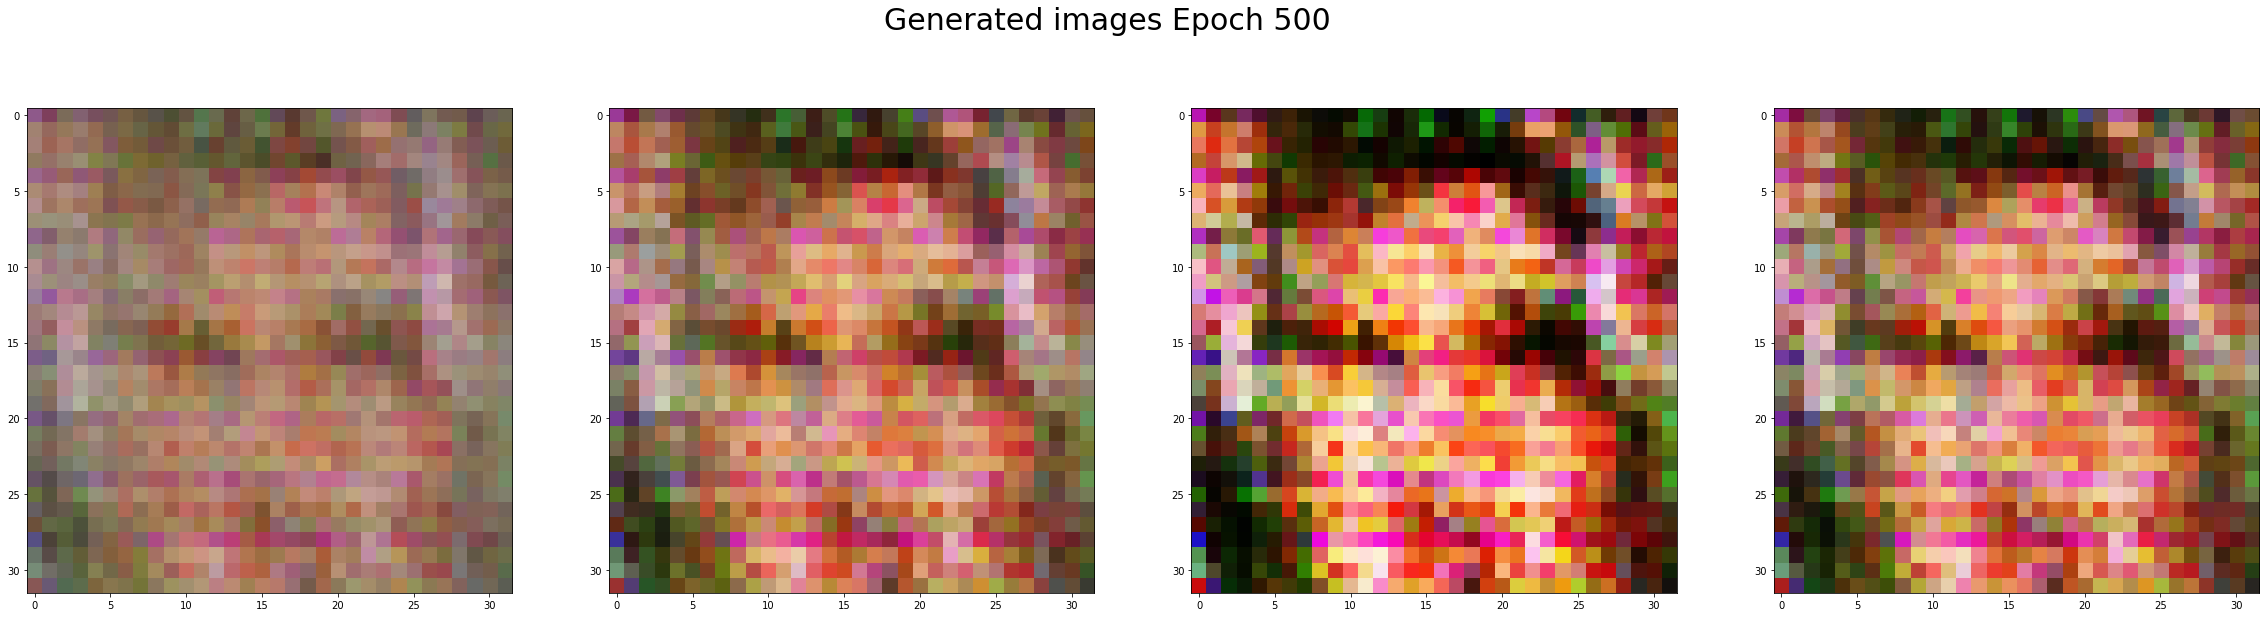

Epoch 01000 [D loss: 0.378, acc.: 085.2%] [G loss: 2.895]


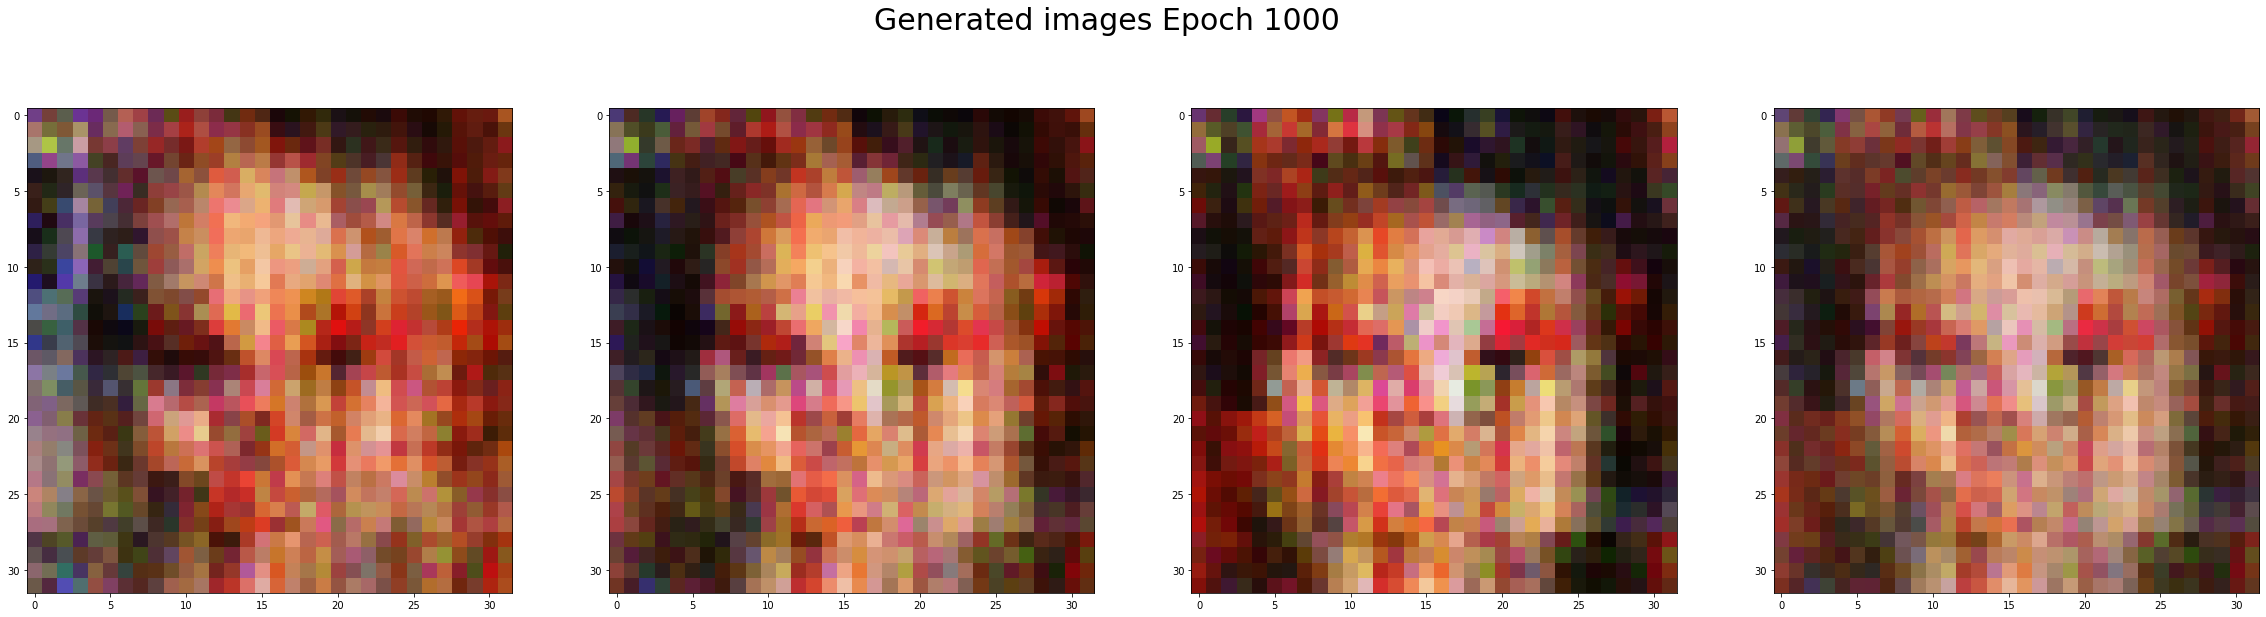

Epoch 01500 [D loss: 0.414, acc.: 078.5%] [G loss: 2.515]


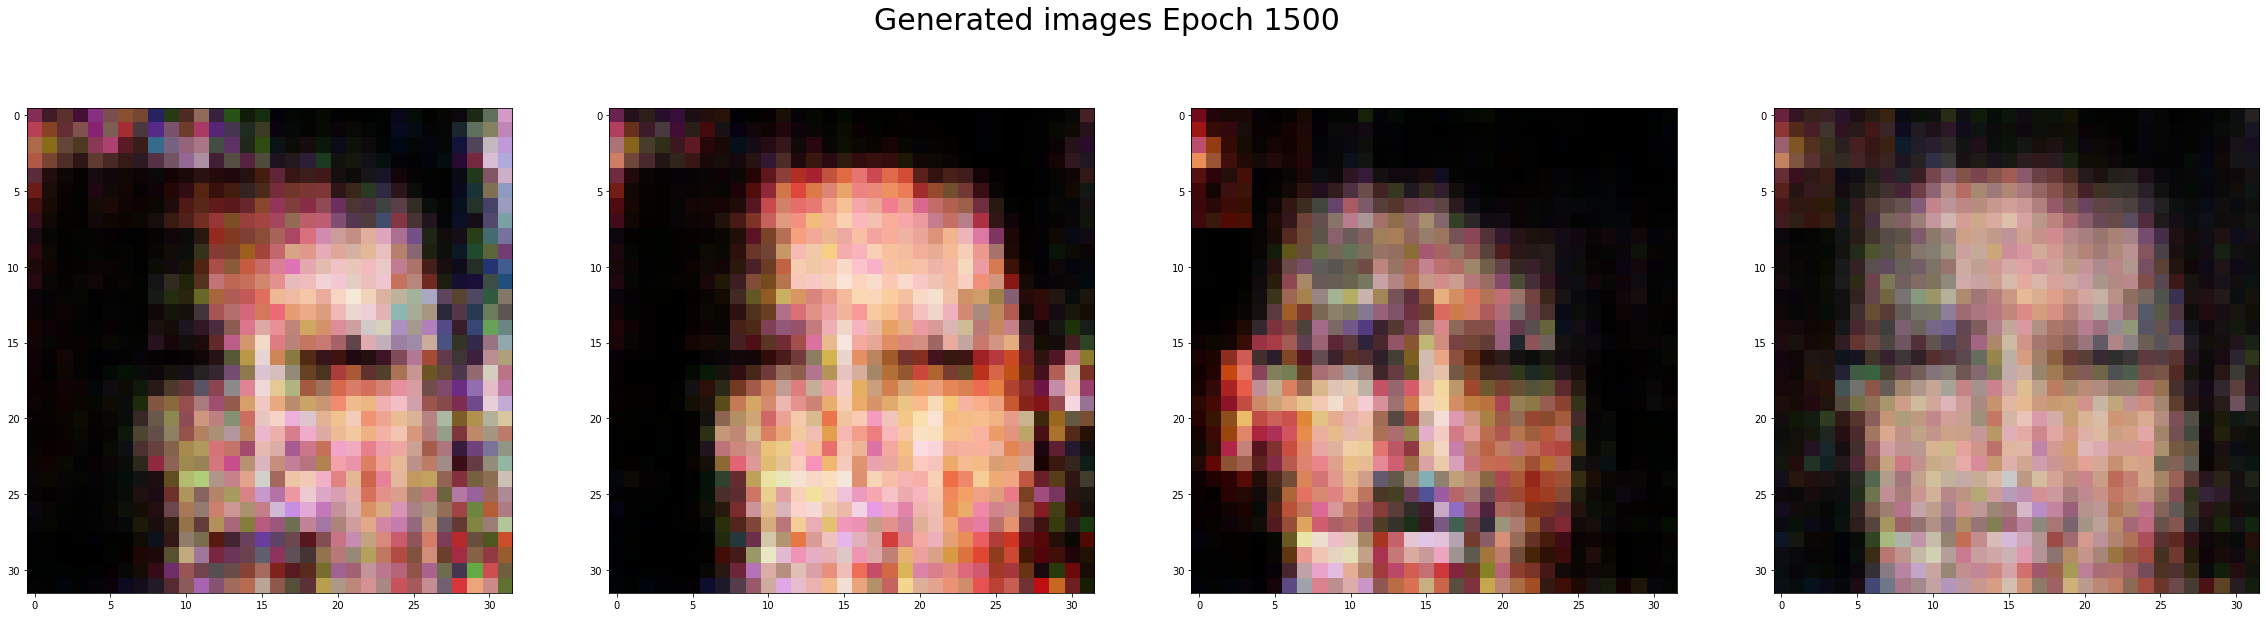

Epoch 02000 [D loss: 0.467, acc.: 078.1%] [G loss: 1.778]


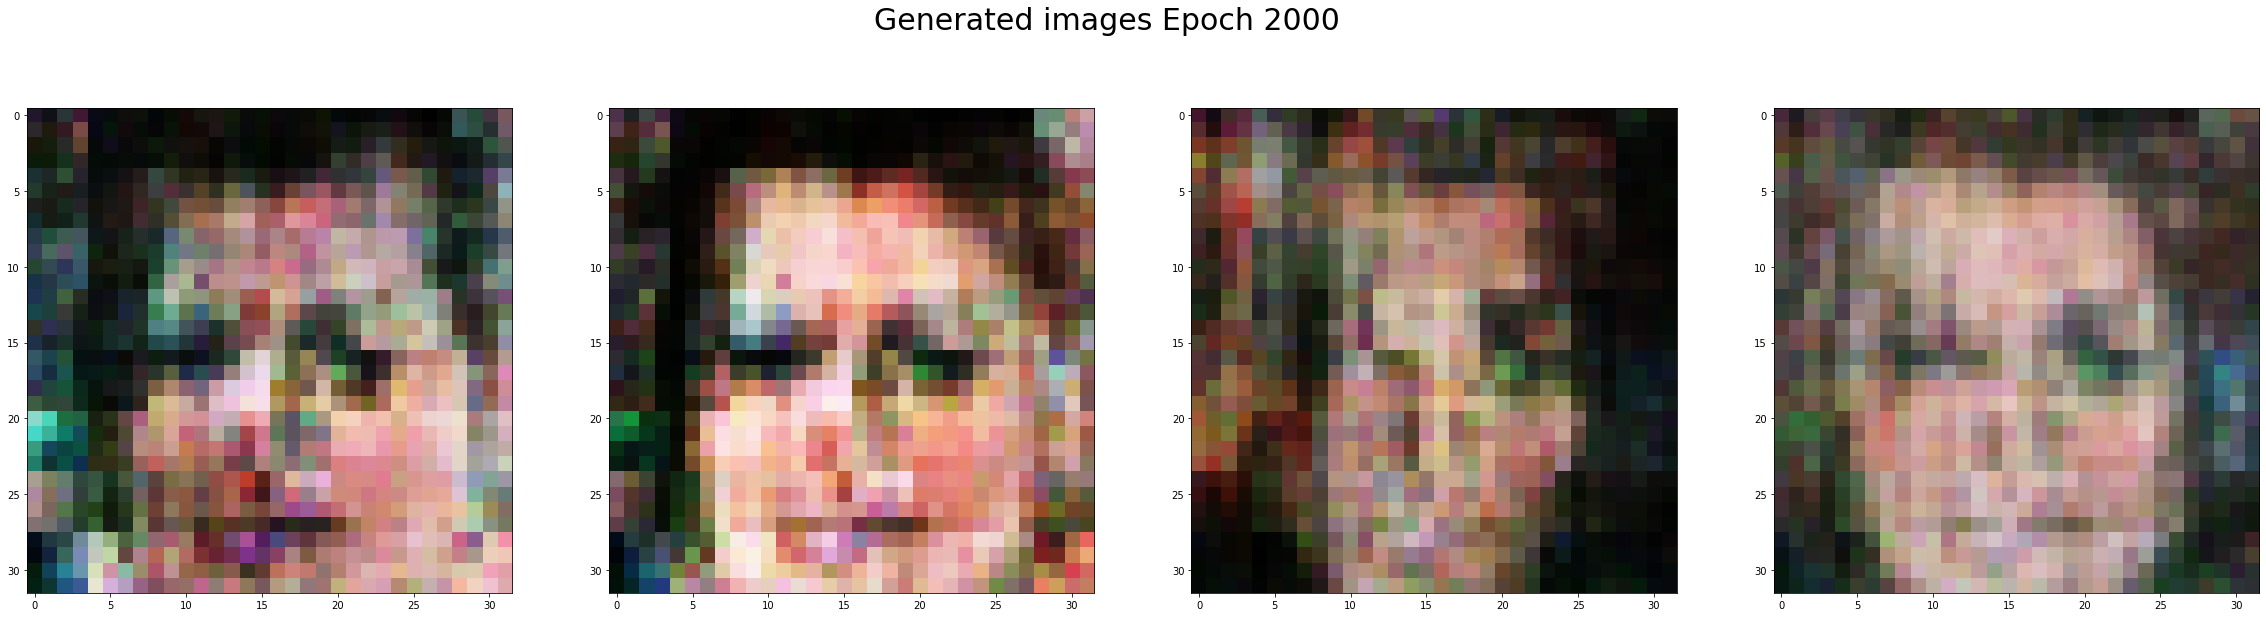

Epoch 02500 [D loss: 0.398, acc.: 084.8%] [G loss: 1.575]


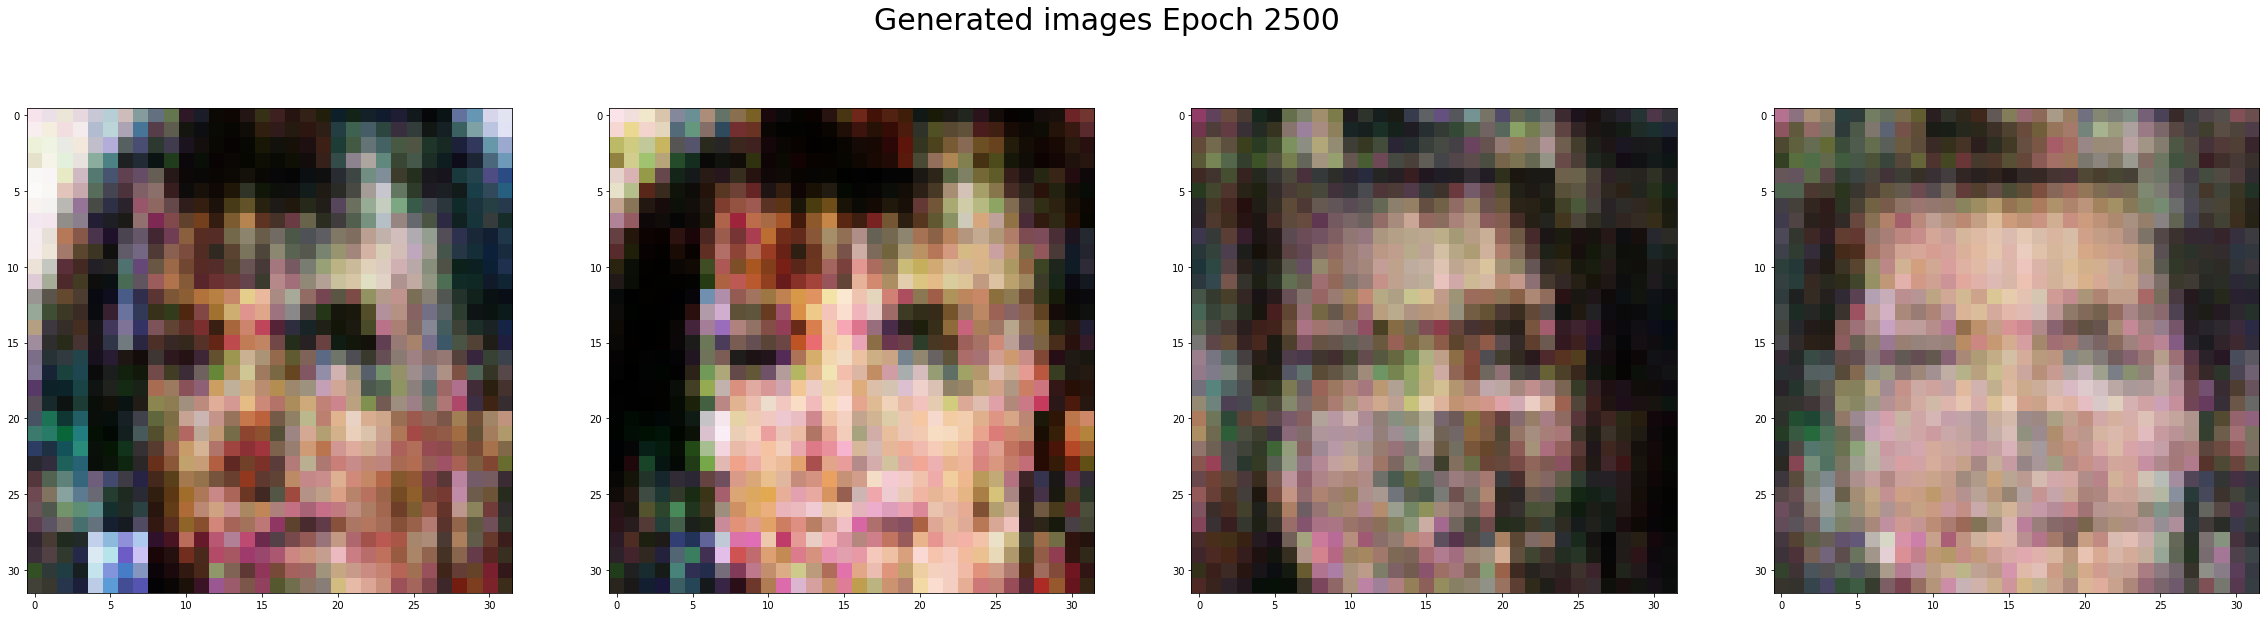

Epoch 03000 [D loss: 0.478, acc.: 077.0%] [G loss: 1.520]


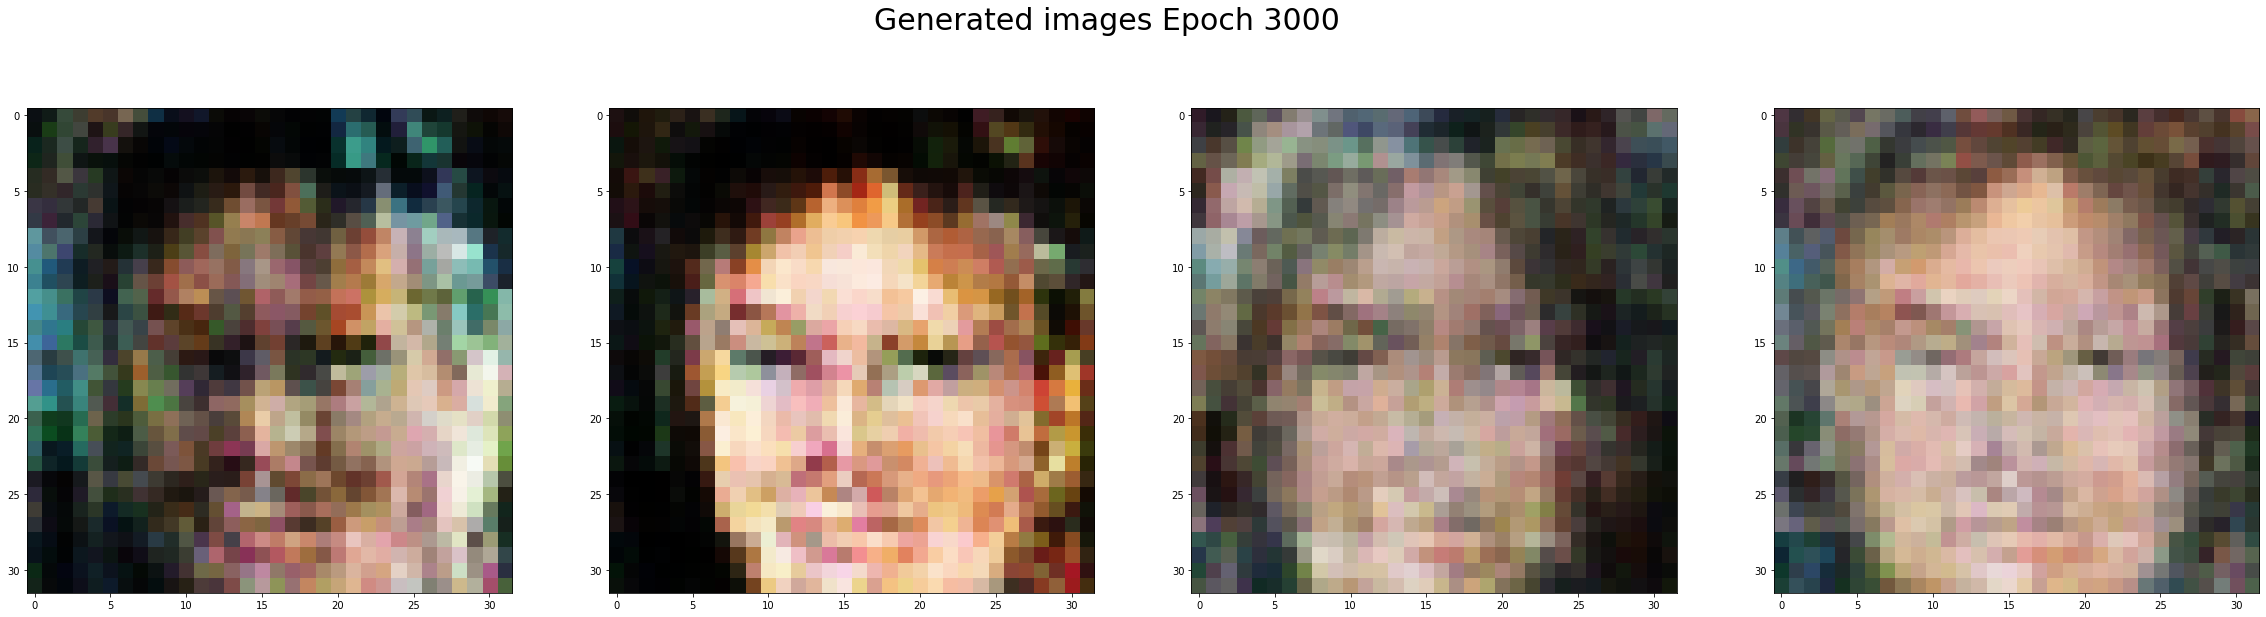

Epoch 03500 [D loss: 0.489, acc.: 077.3%] [G loss: 1.565]


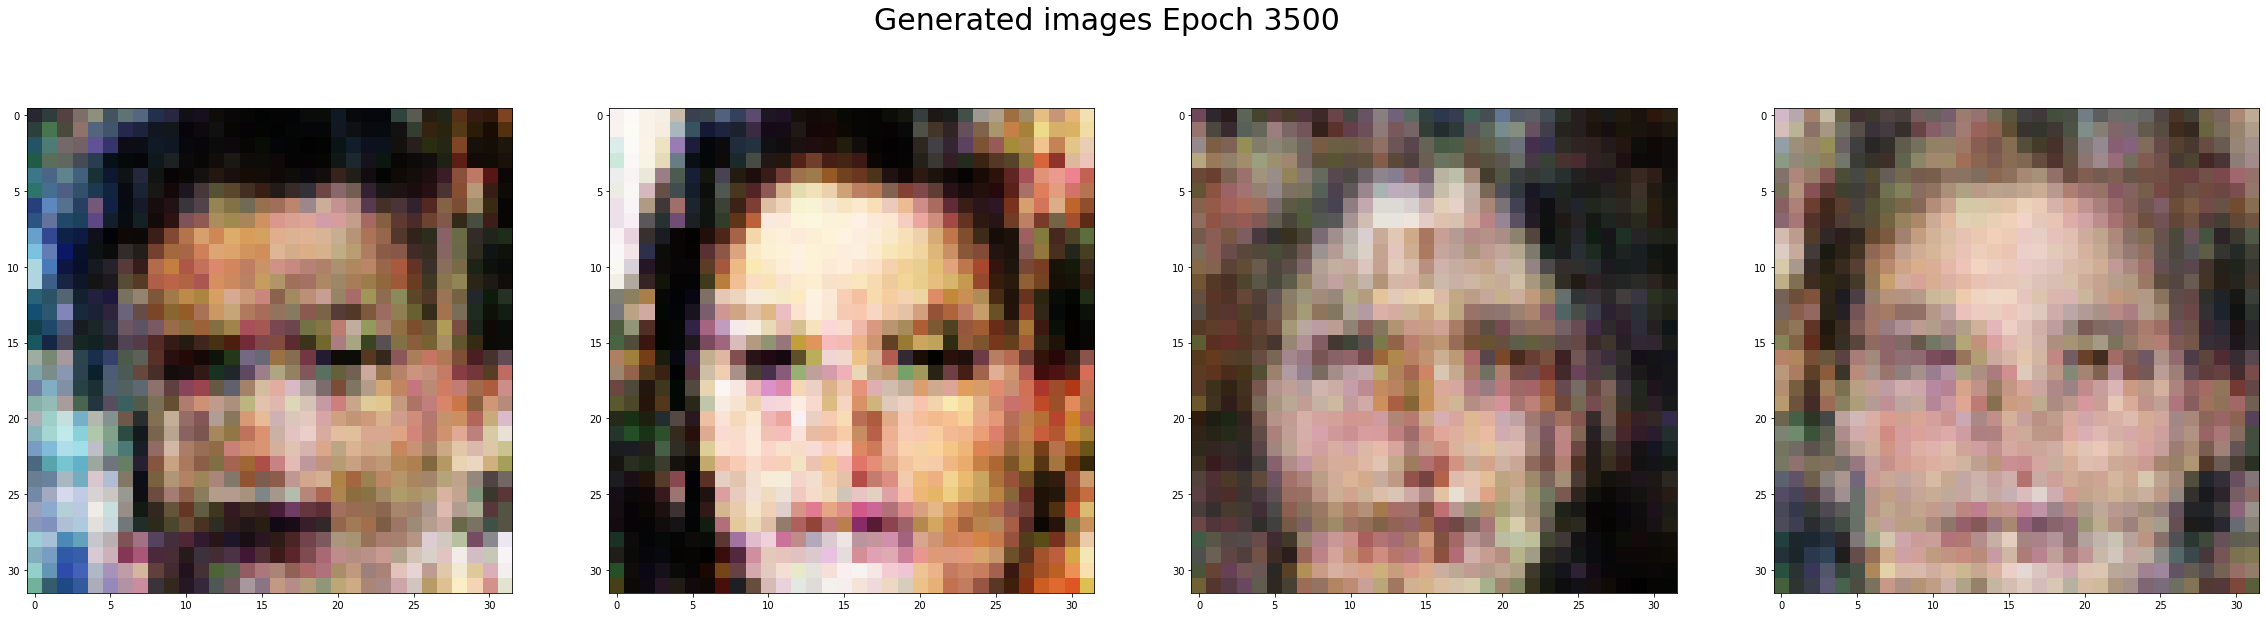

Epoch 04000 [D loss: 0.490, acc.: 076.6%] [G loss: 1.543]


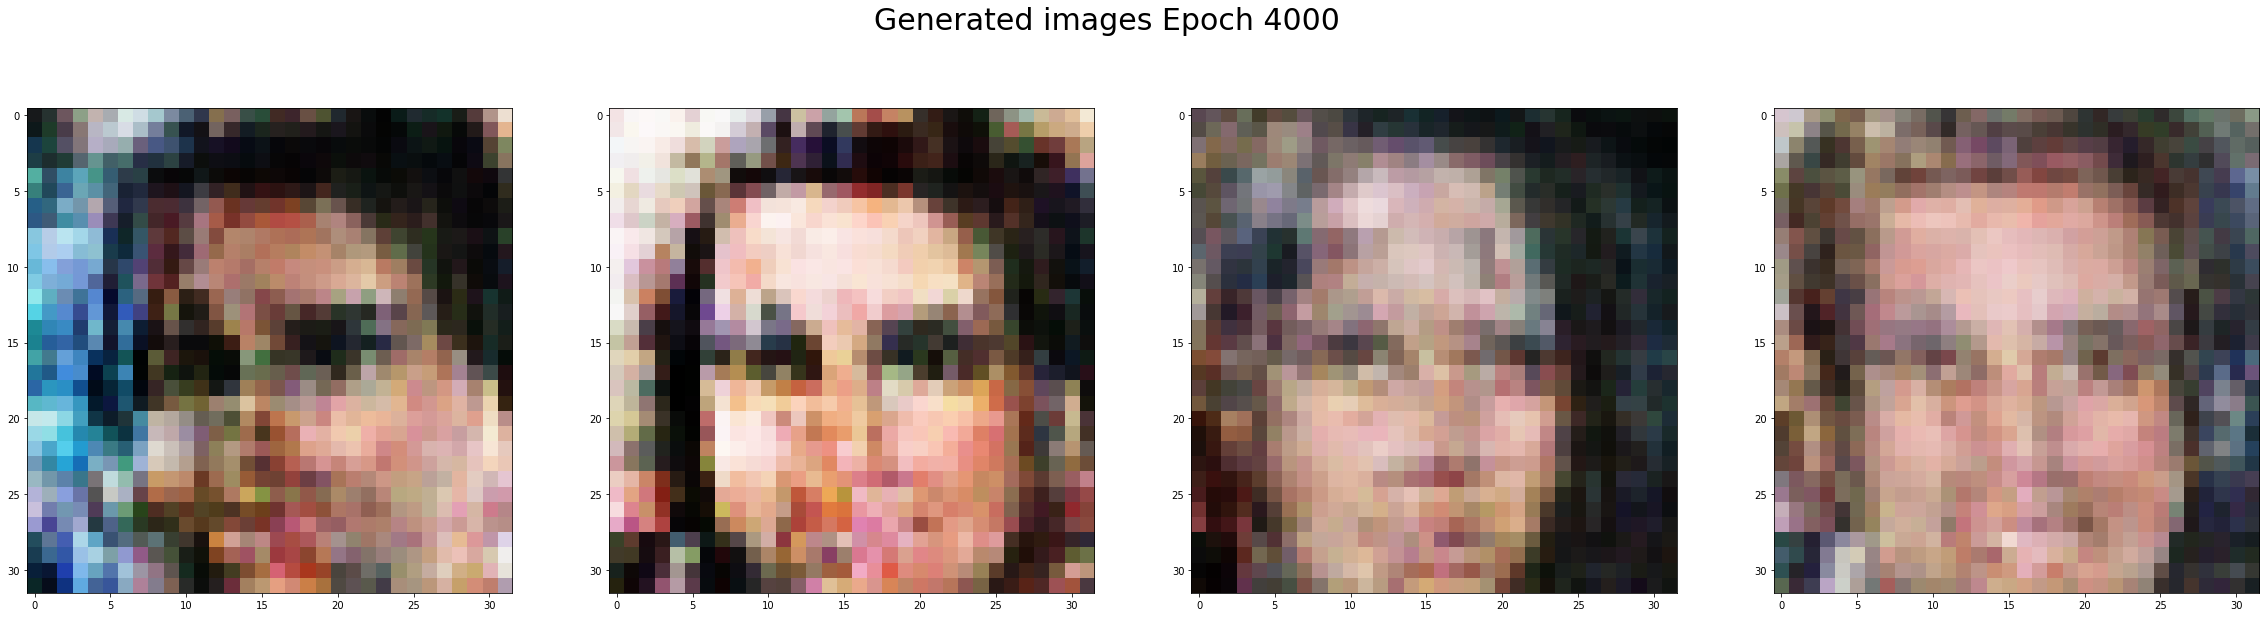

Epoch 04500 [D loss: 0.510, acc.: 076.6%] [G loss: 1.537]


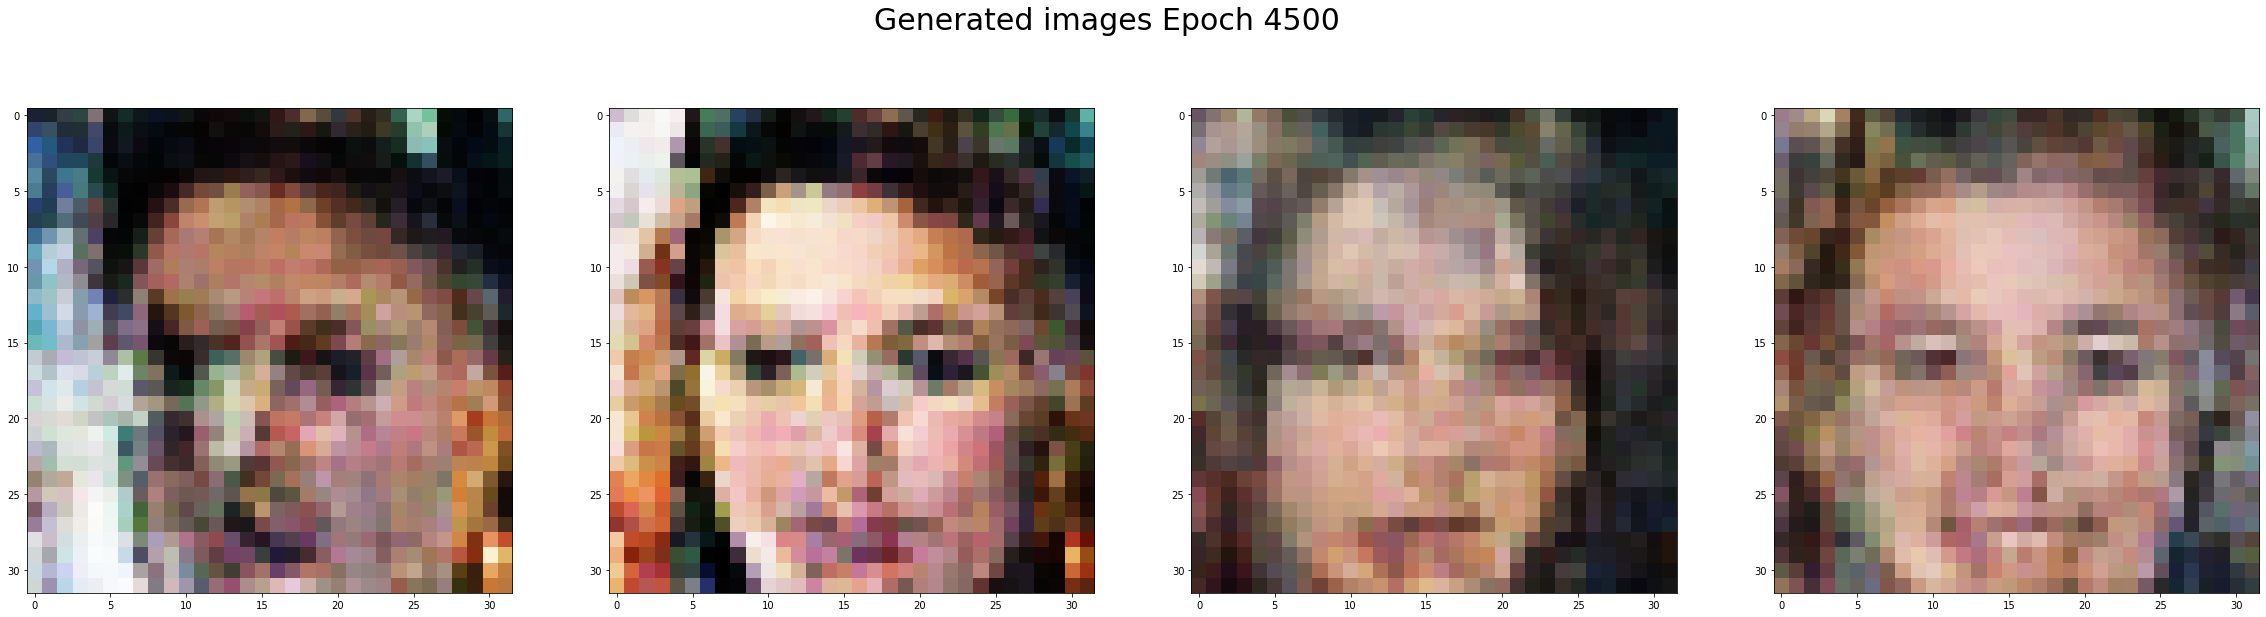

Epoch 05000 [D loss: 0.539, acc.: 072.3%] [G loss: 1.398]


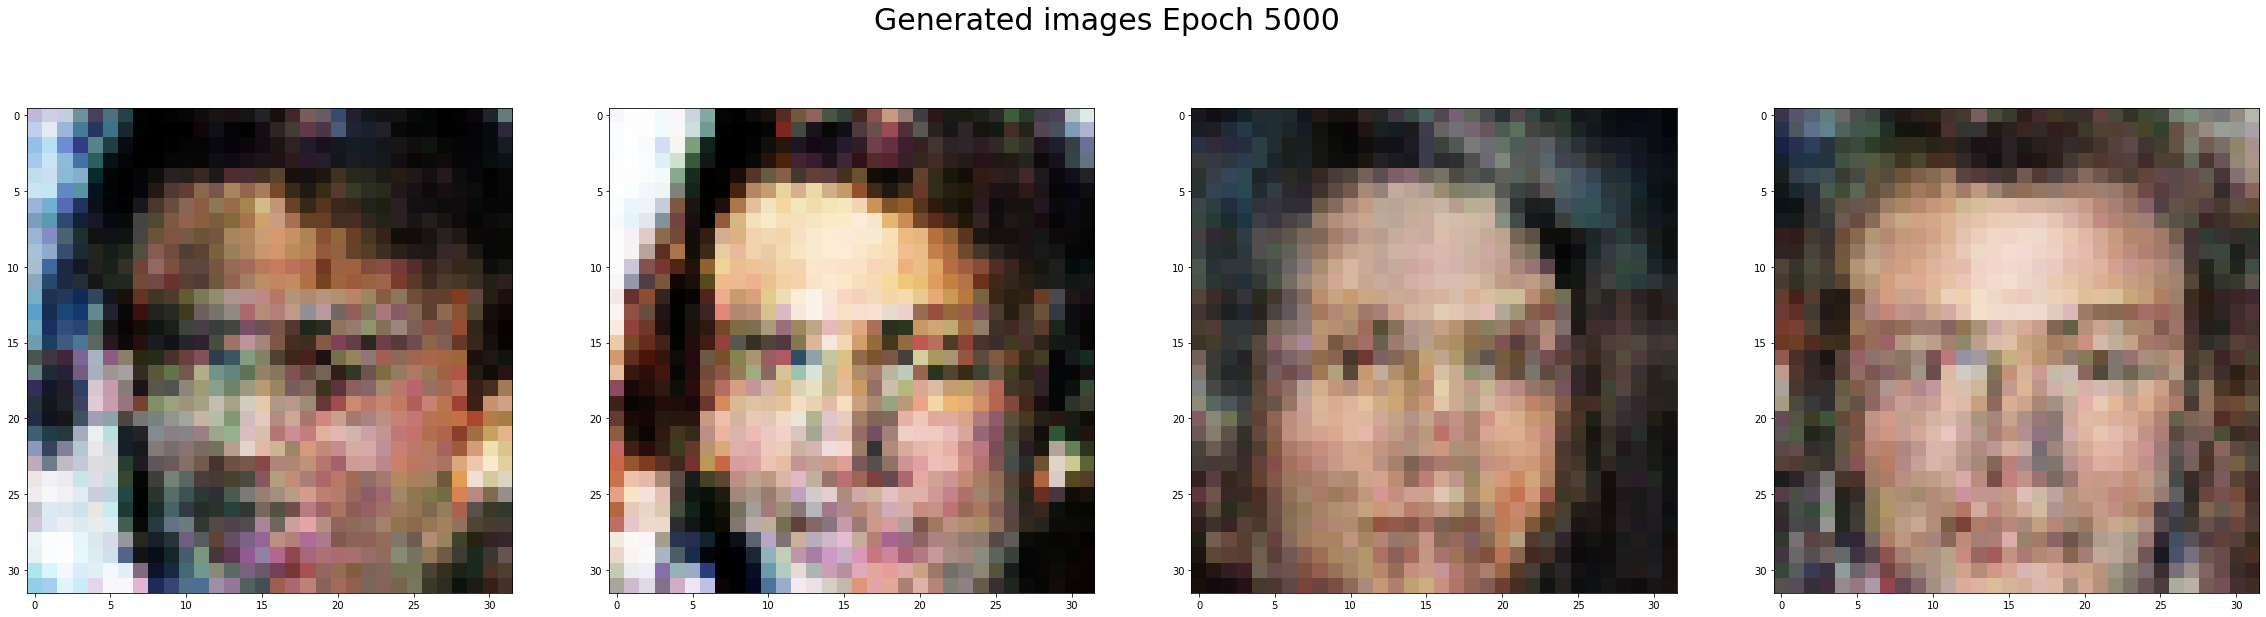

Epoch 05500 [D loss: 0.496, acc.: 076.2%] [G loss: 1.407]


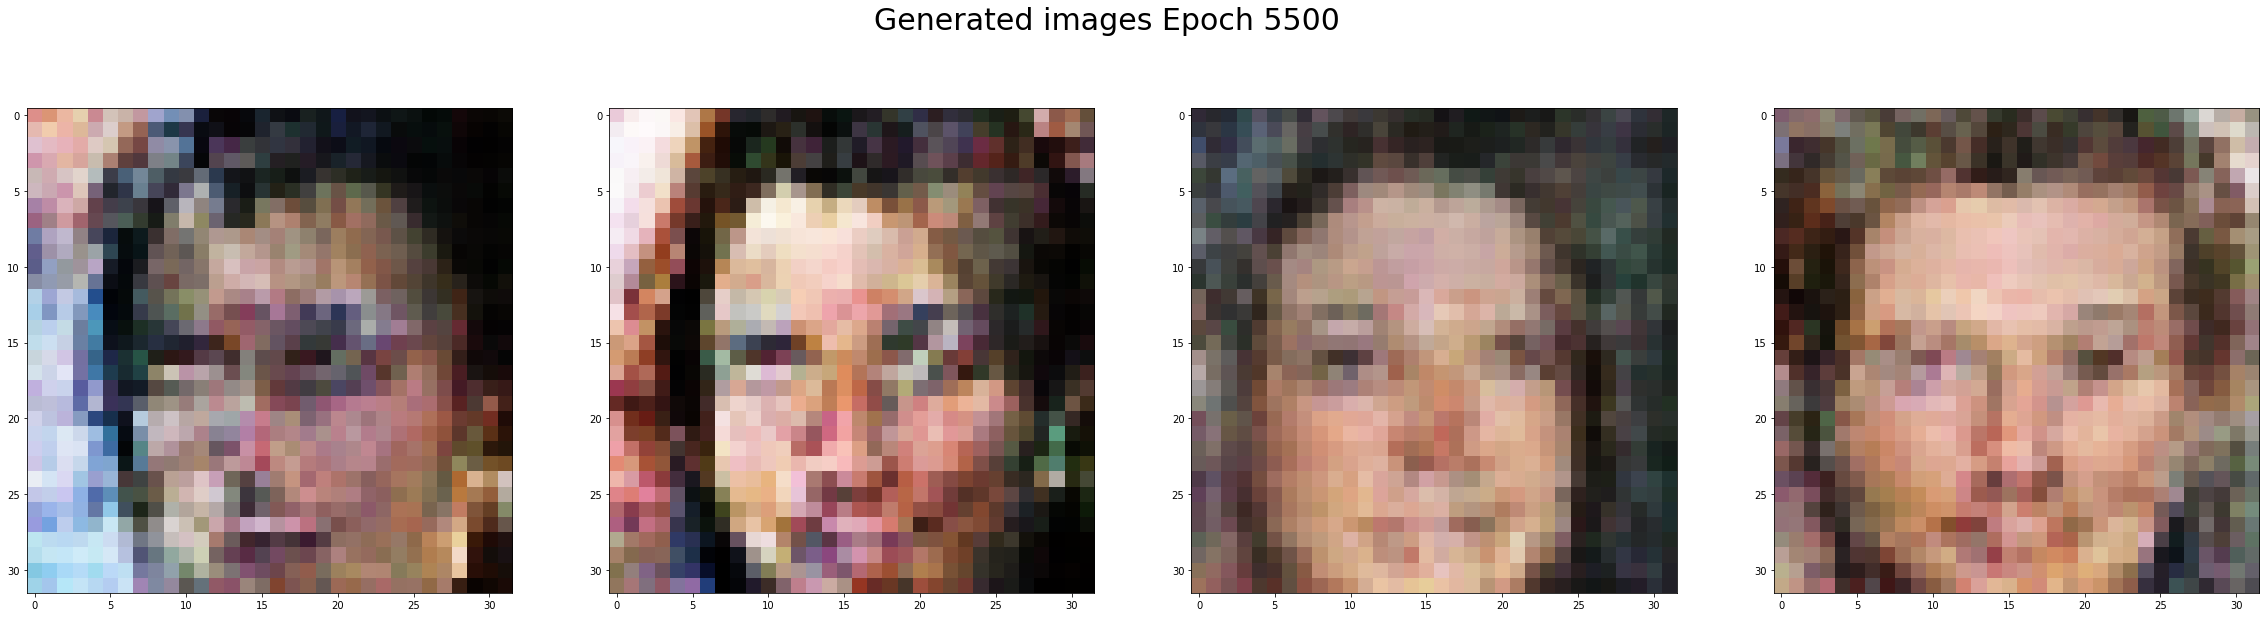

Epoch 06000 [D loss: 0.469, acc.: 077.0%] [G loss: 1.308]


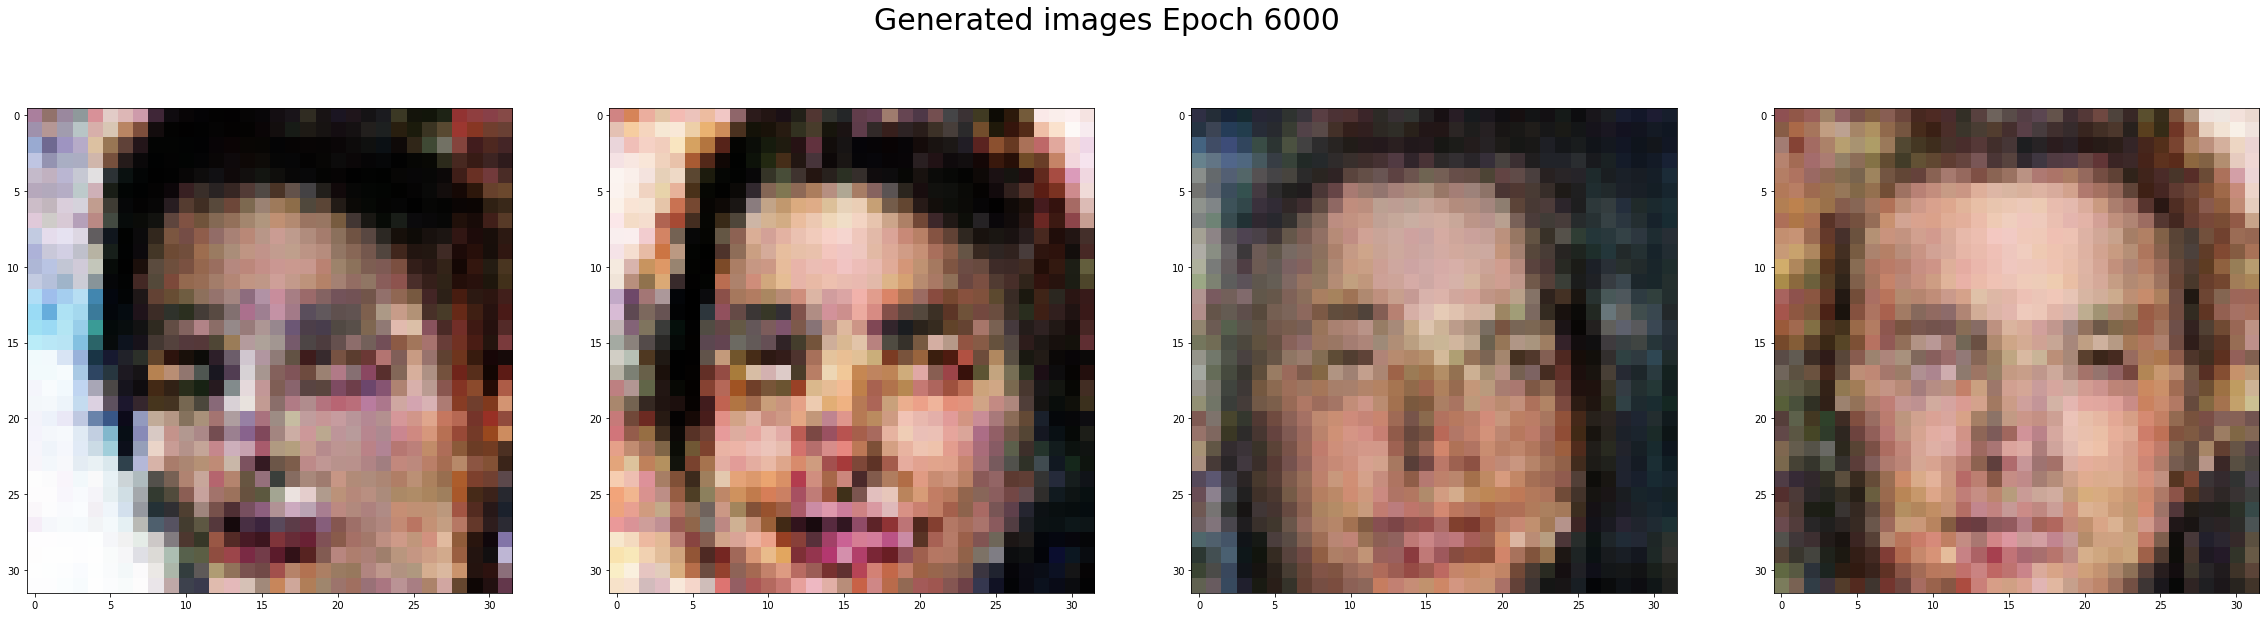

Epoch 06500 [D loss: 0.472, acc.: 077.7%] [G loss: 1.385]


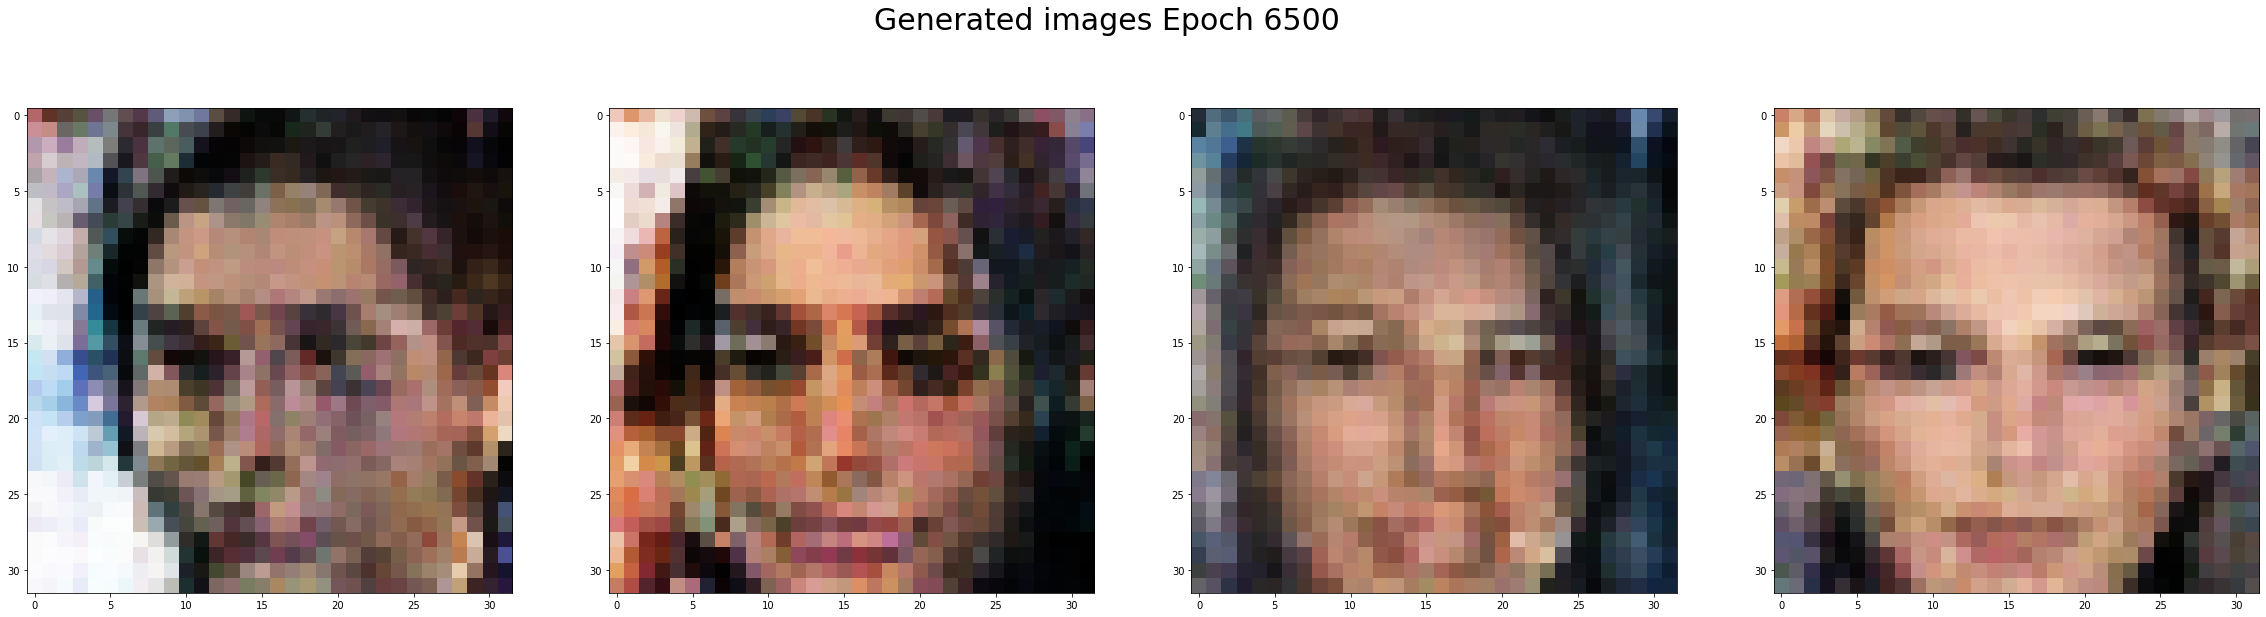

Epoch 07000 [D loss: 0.558, acc.: 070.3%] [G loss: 1.424]


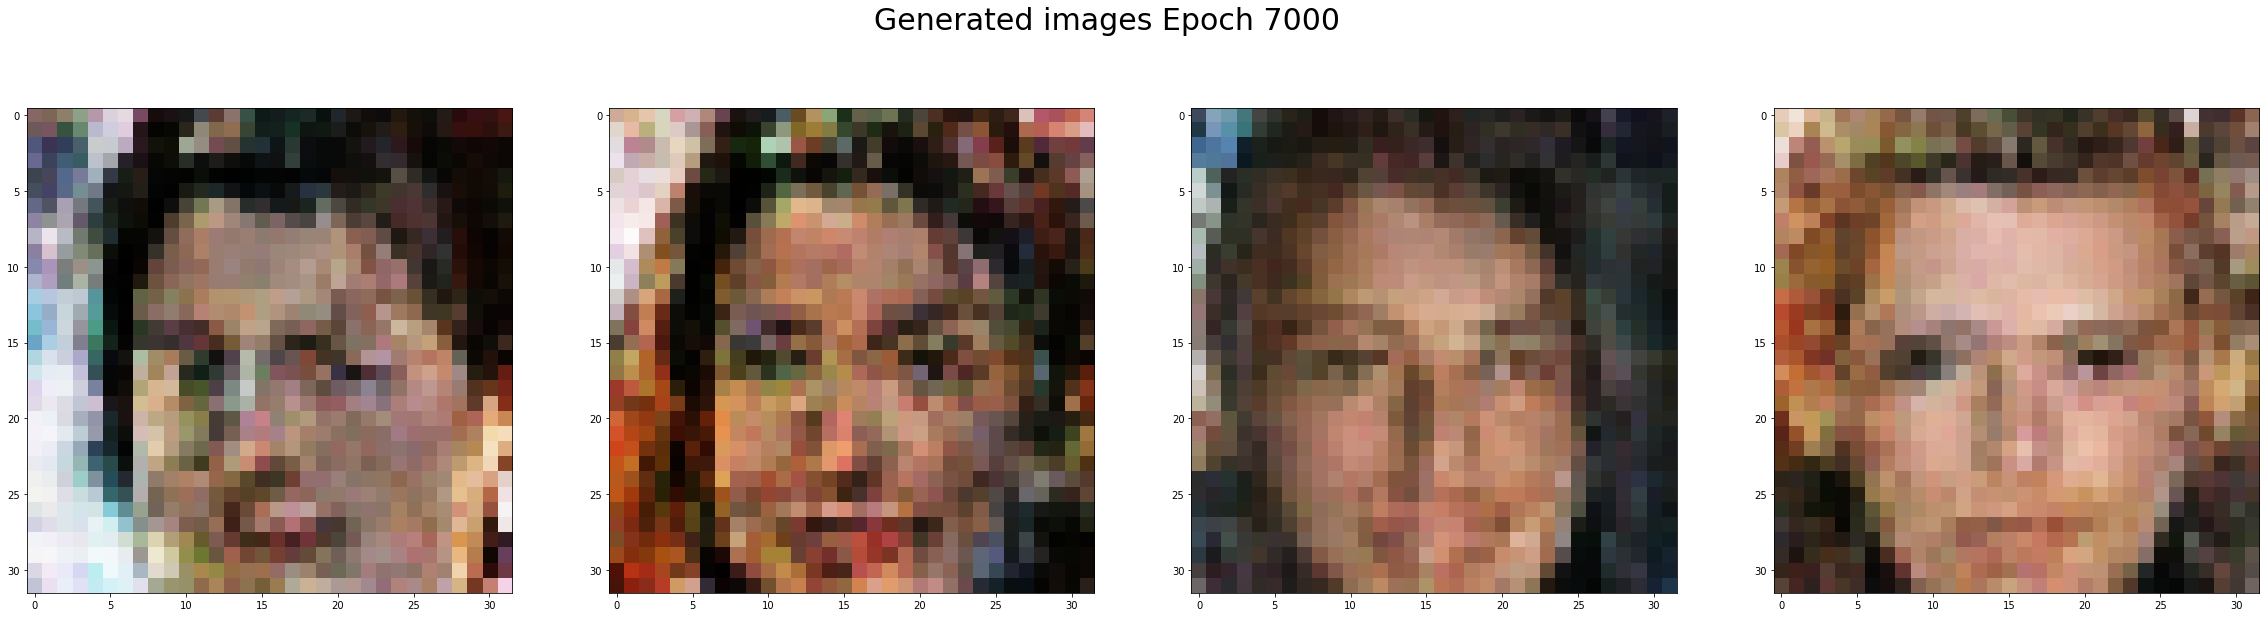

Epoch 07500 [D loss: 0.451, acc.: 082.4%] [G loss: 1.438]


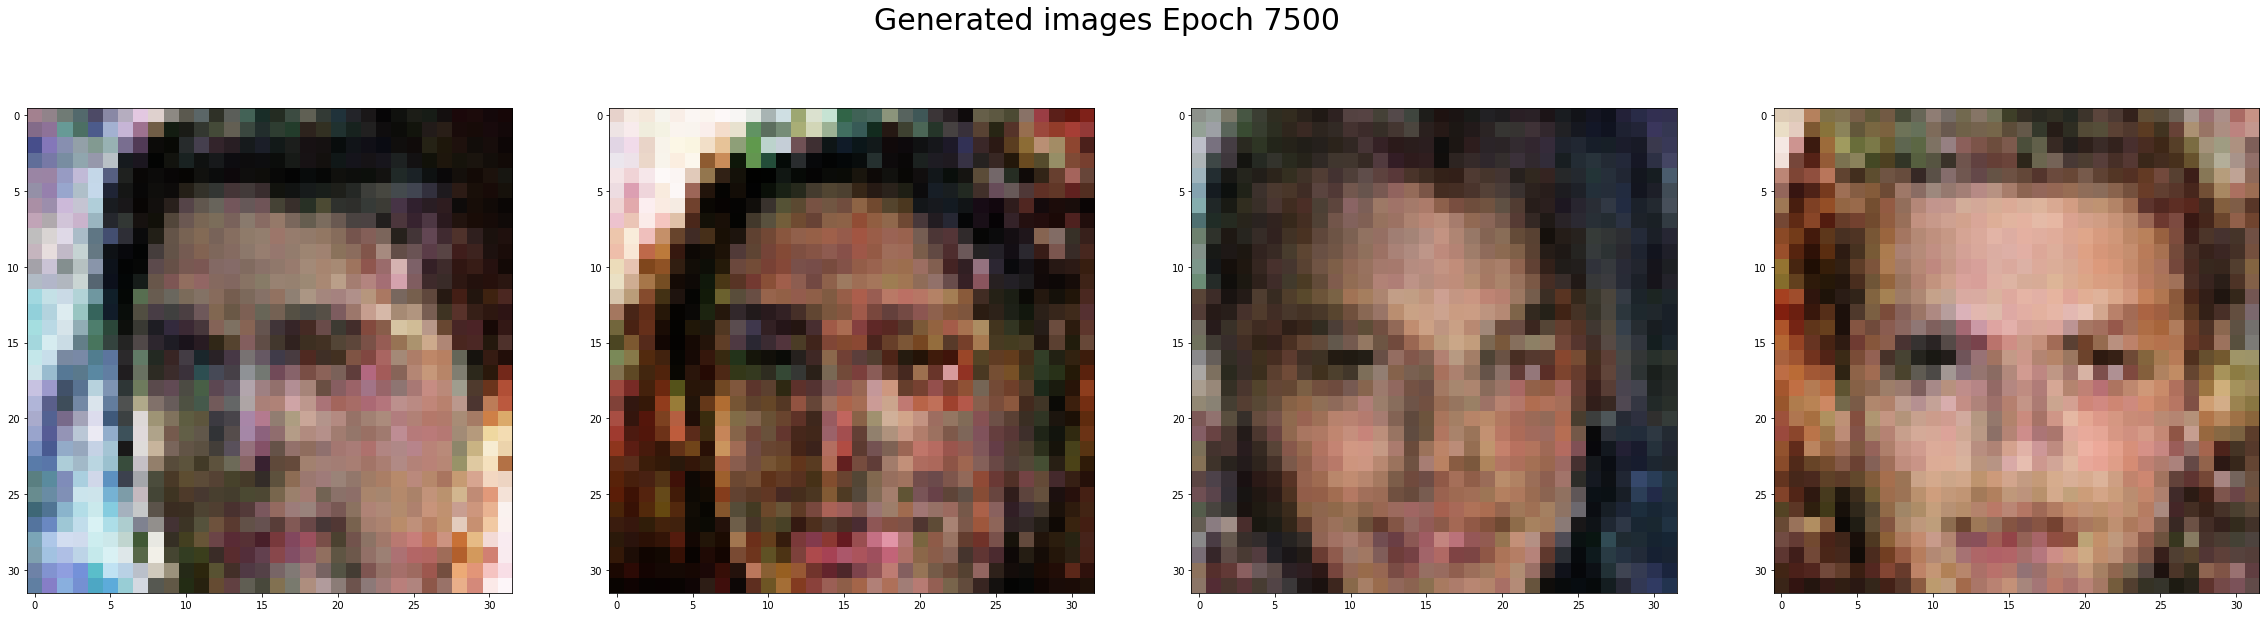

Epoch 08000 [D loss: 0.508, acc.: 075.4%] [G loss: 1.433]


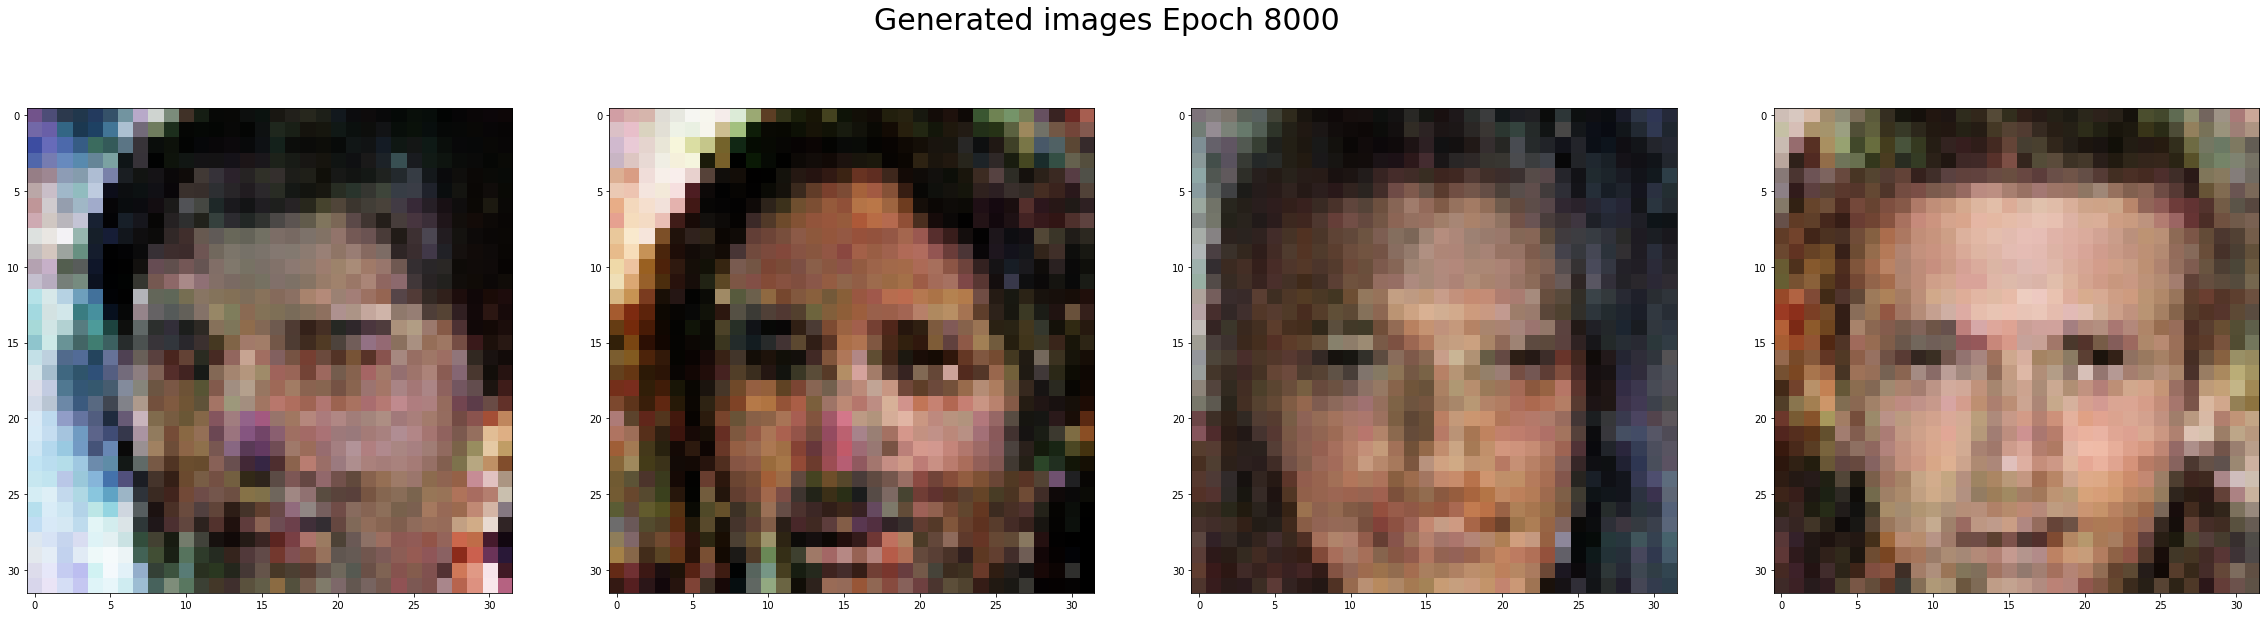

Epoch 08500 [D loss: 0.415, acc.: 082.8%] [G loss: 1.452]


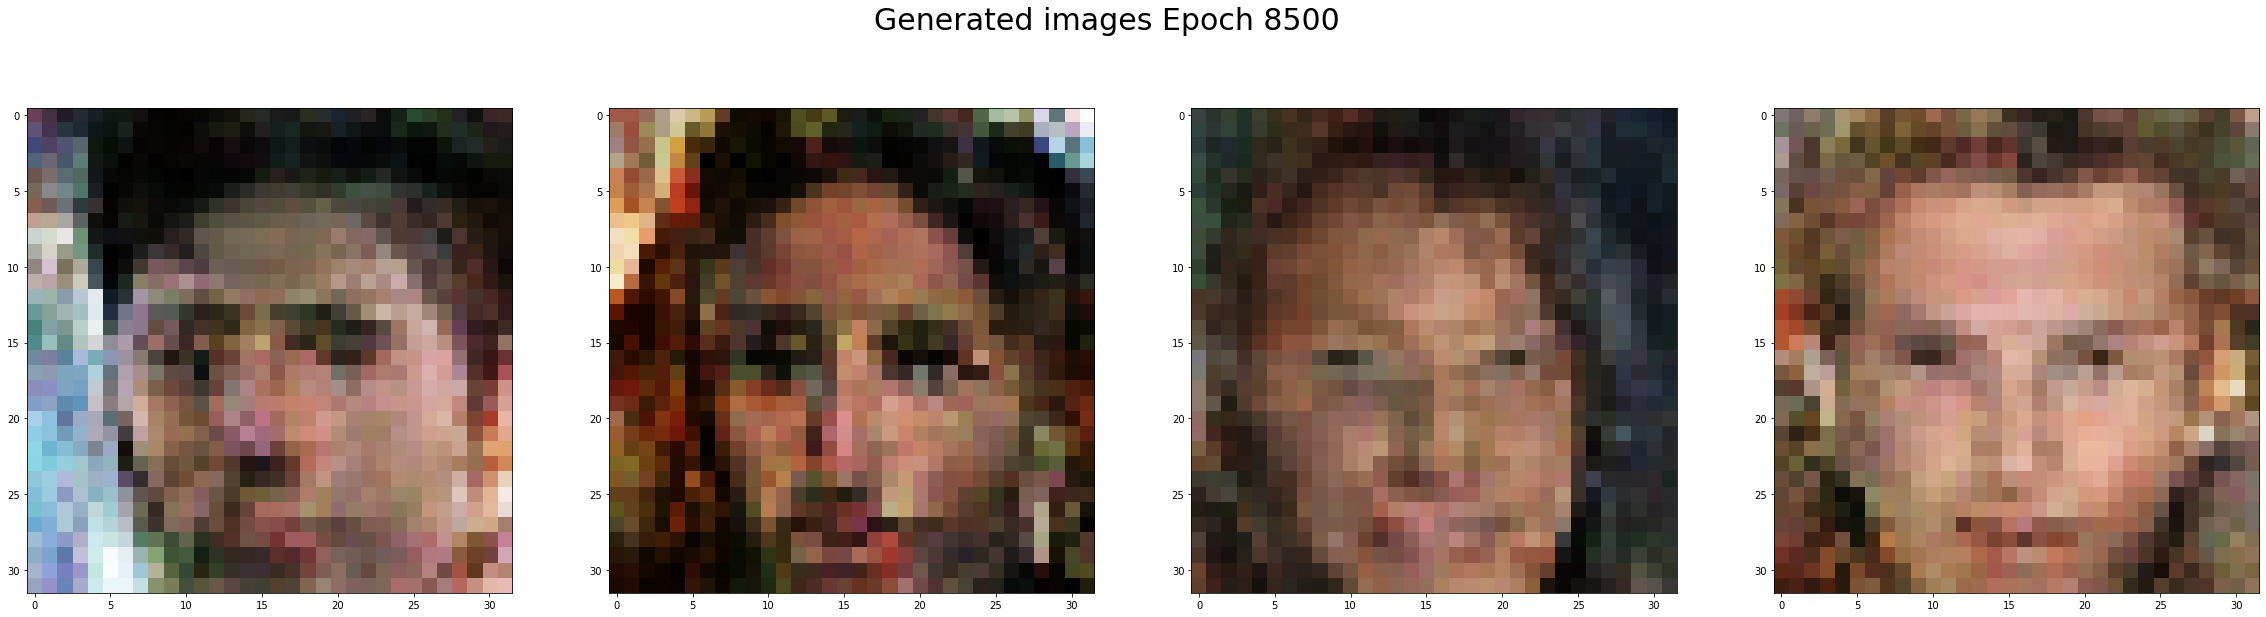

Epoch 09000 [D loss: 0.513, acc.: 073.8%] [G loss: 1.370]


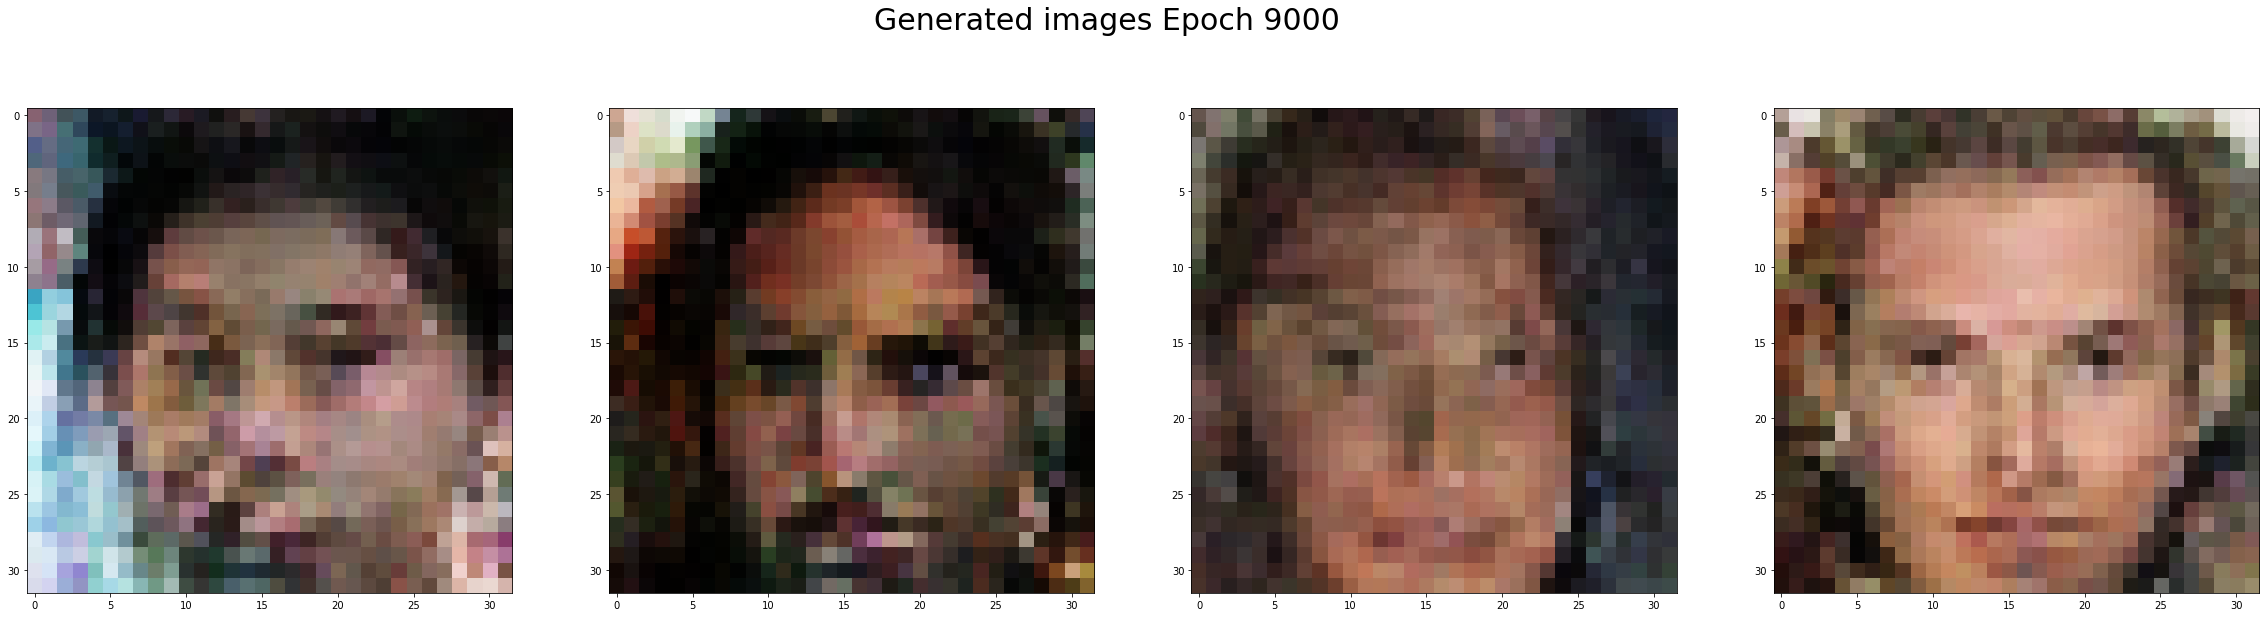

Epoch 09500 [D loss: 0.403, acc.: 083.2%] [G loss: 1.450]


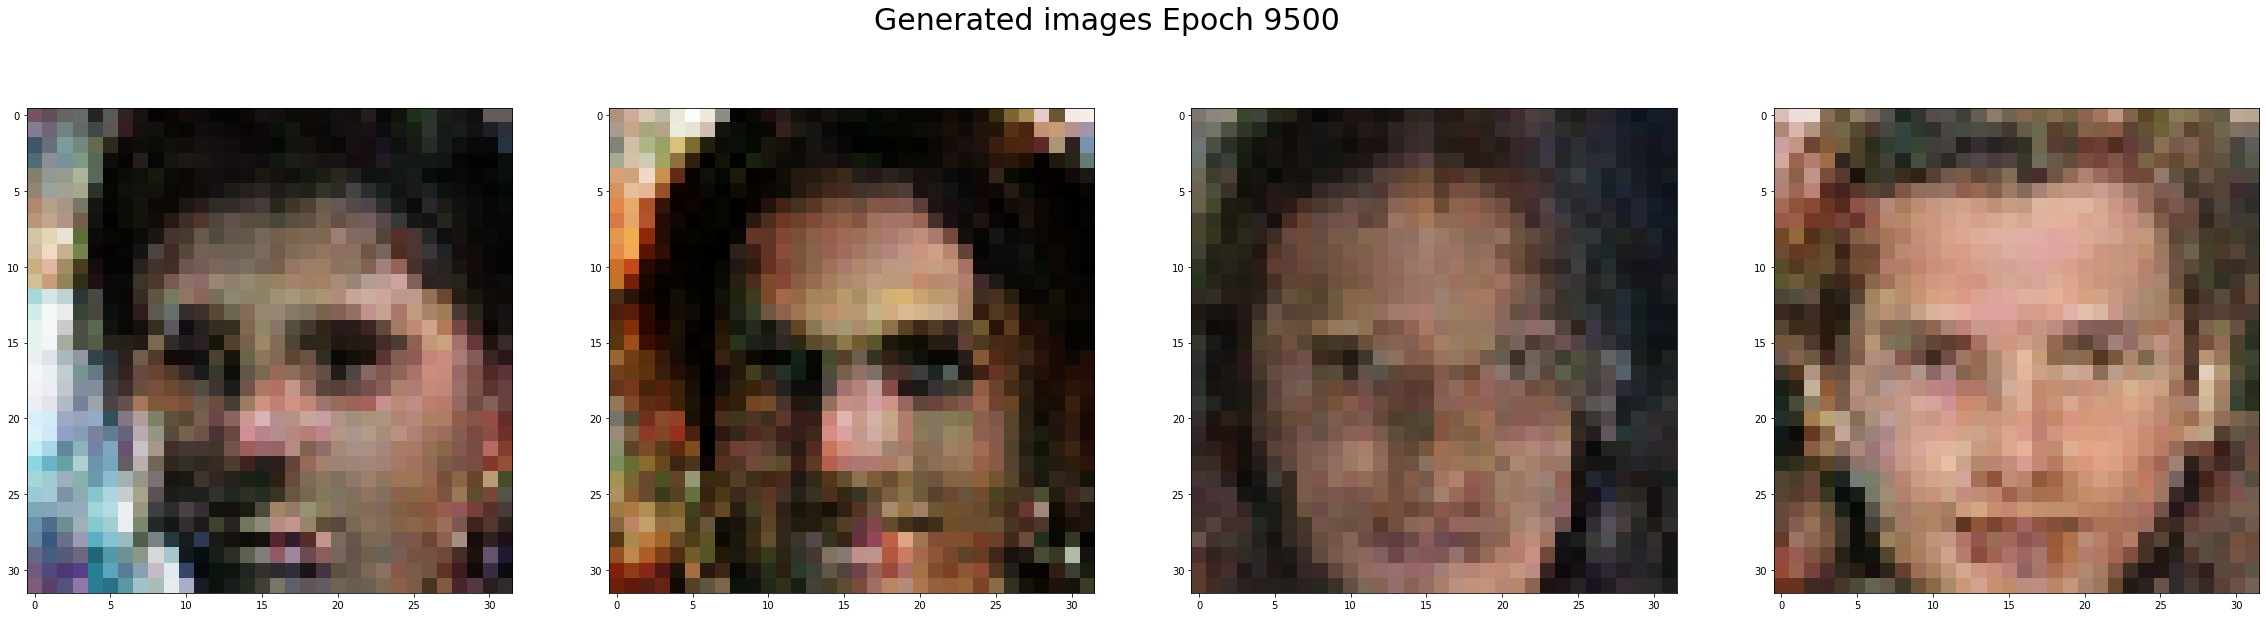

Epoch 10000 [D loss: 0.526, acc.: 073.4%] [G loss: 1.402]


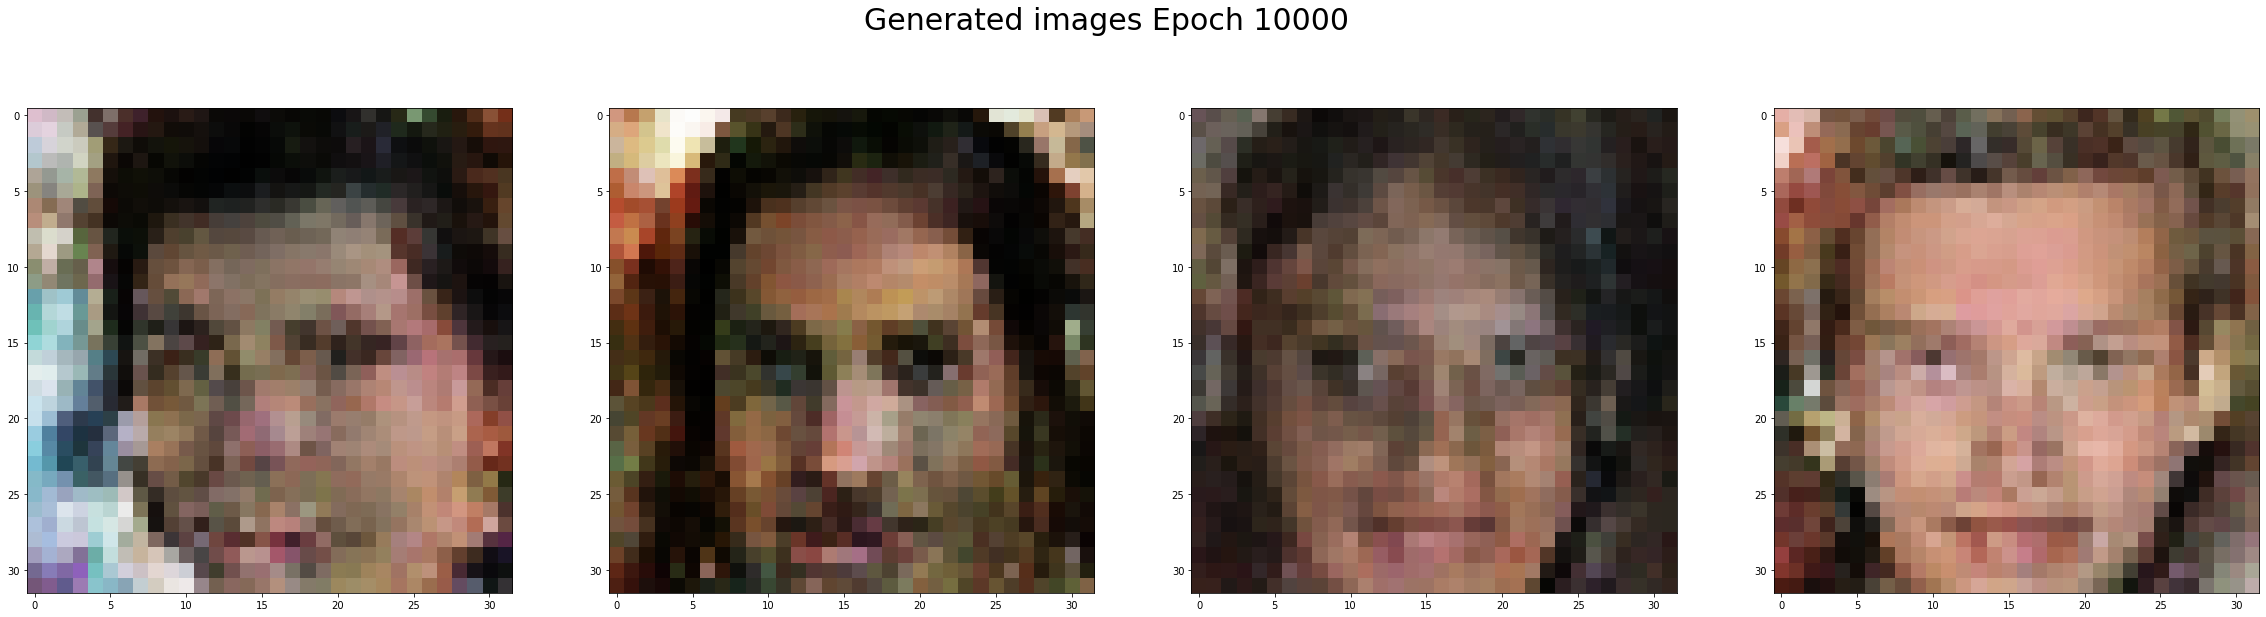

Epoch 10500 [D loss: 0.418, acc.: 083.2%] [G loss: 1.505]


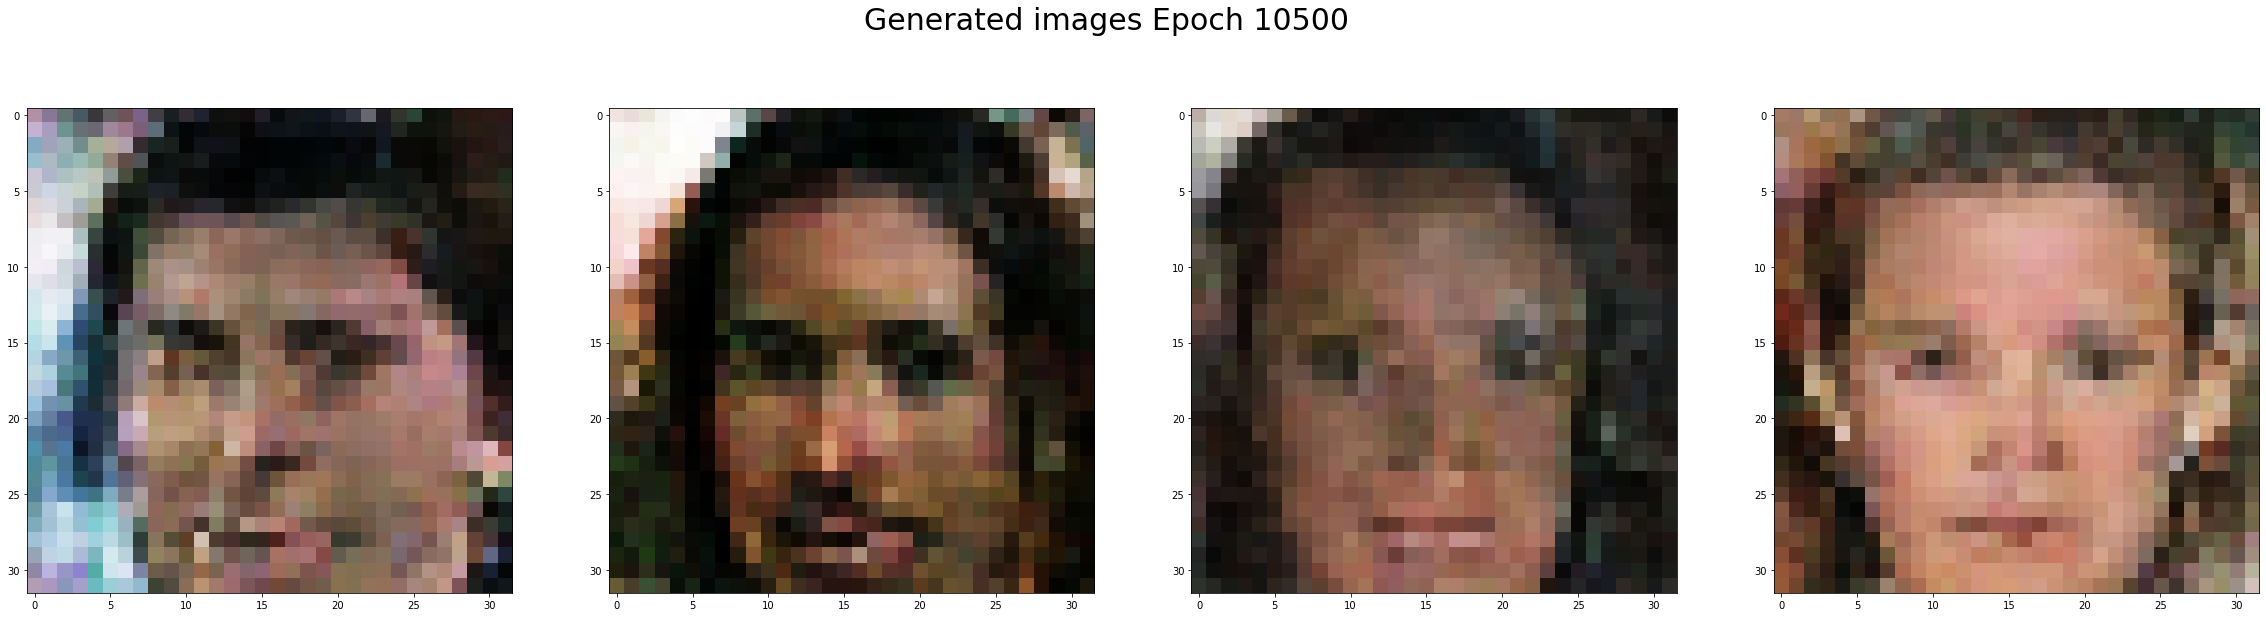

Epoch 11000 [D loss: 0.469, acc.: 078.9%] [G loss: 1.566]


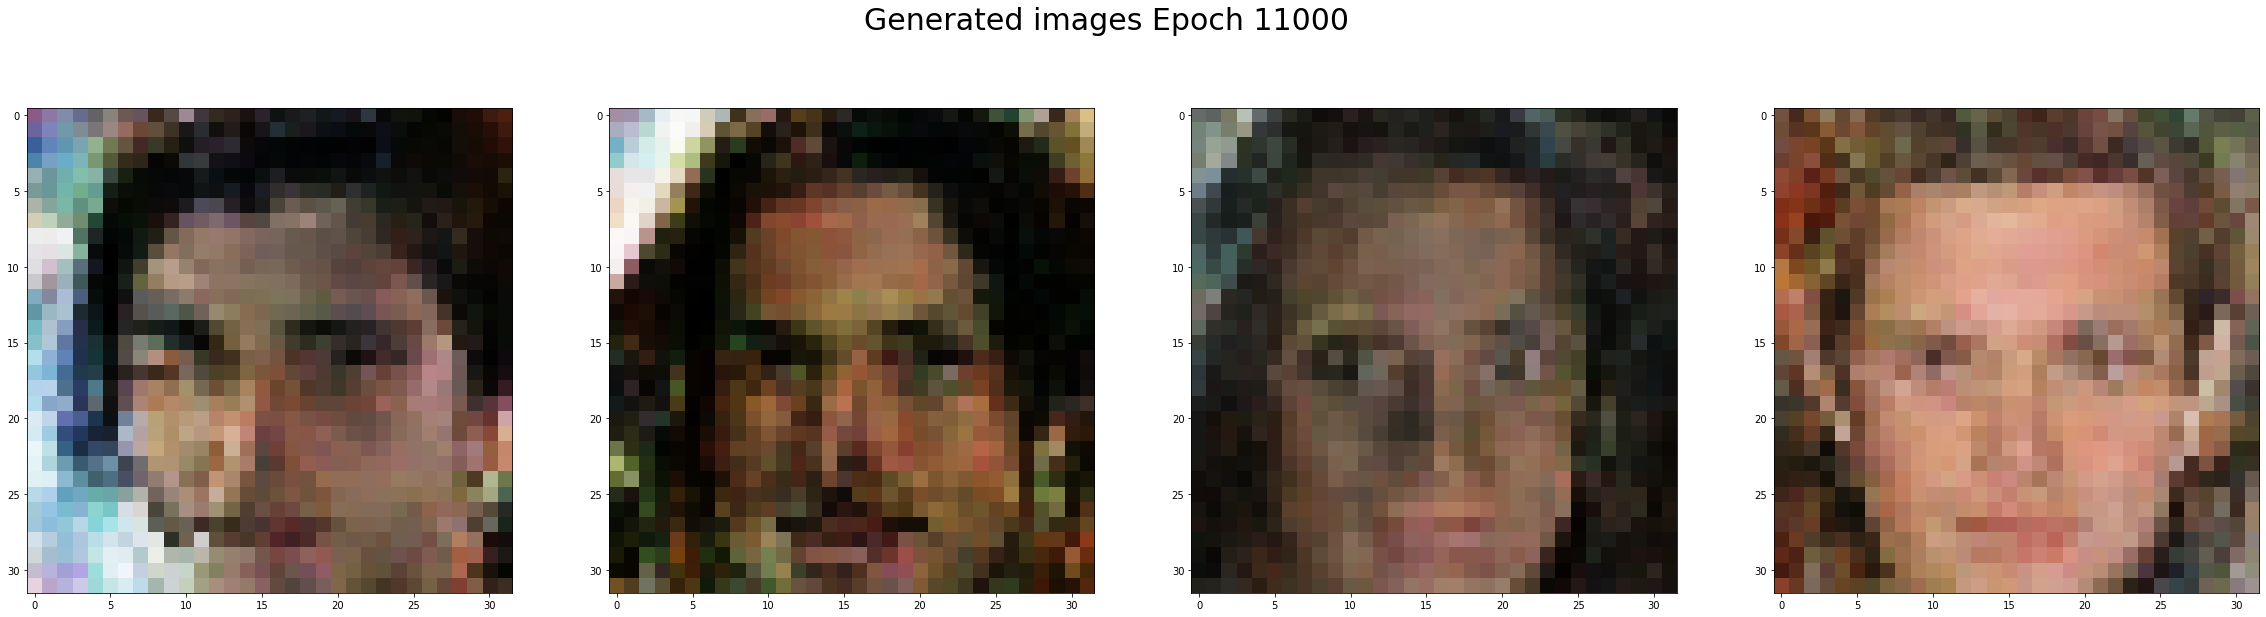

Epoch 11500 [D loss: 0.423, acc.: 080.1%] [G loss: 1.546]


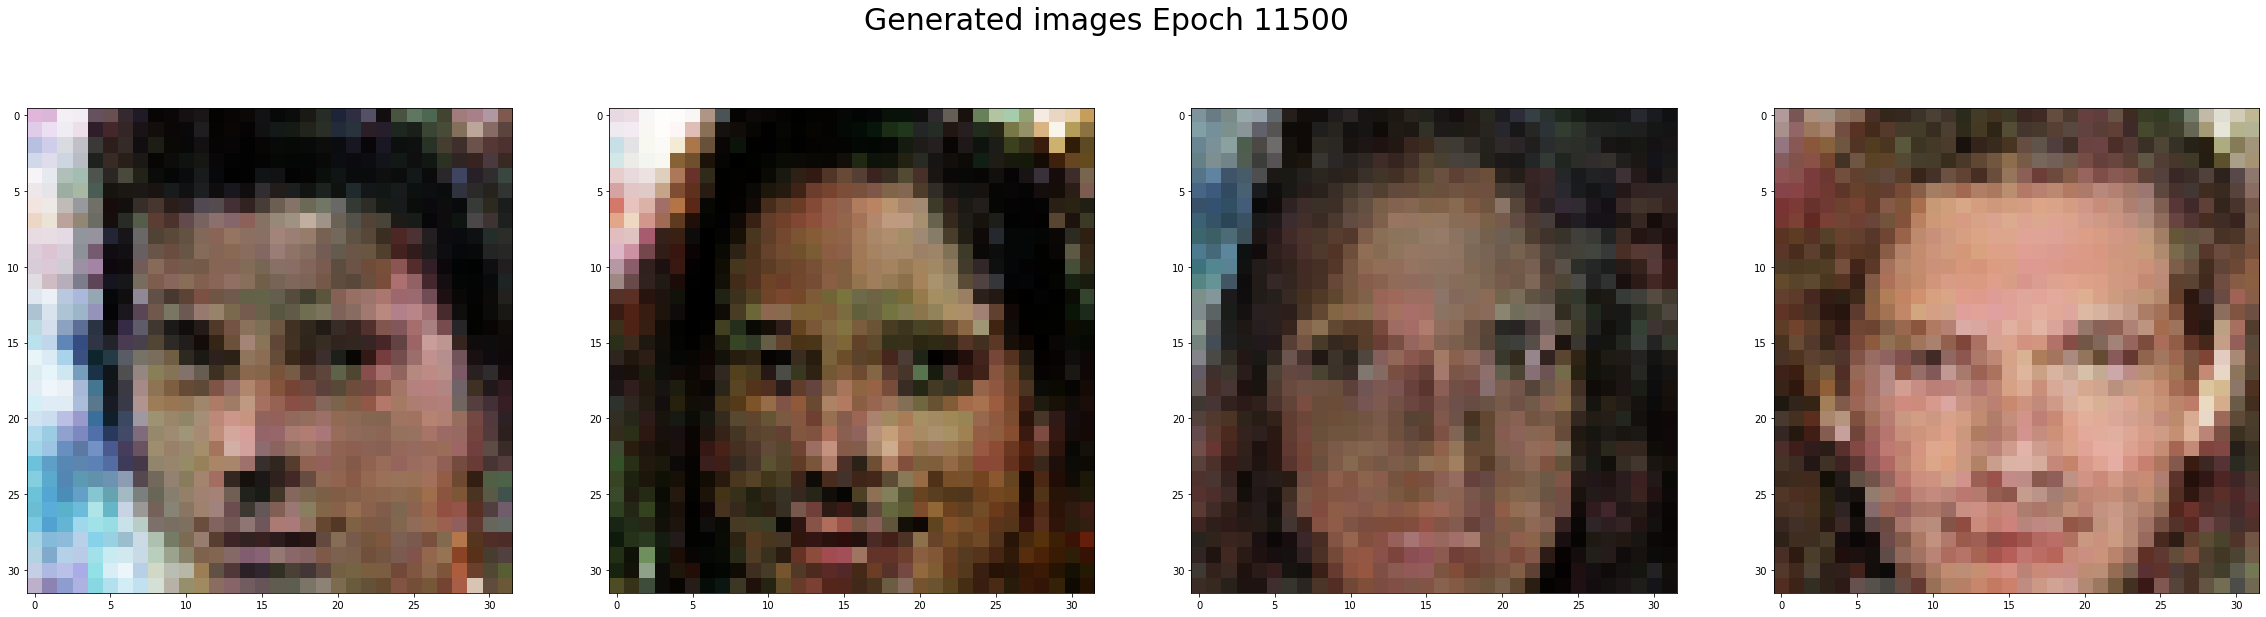

Epoch 12000 [D loss: 0.409, acc.: 081.6%] [G loss: 1.661]


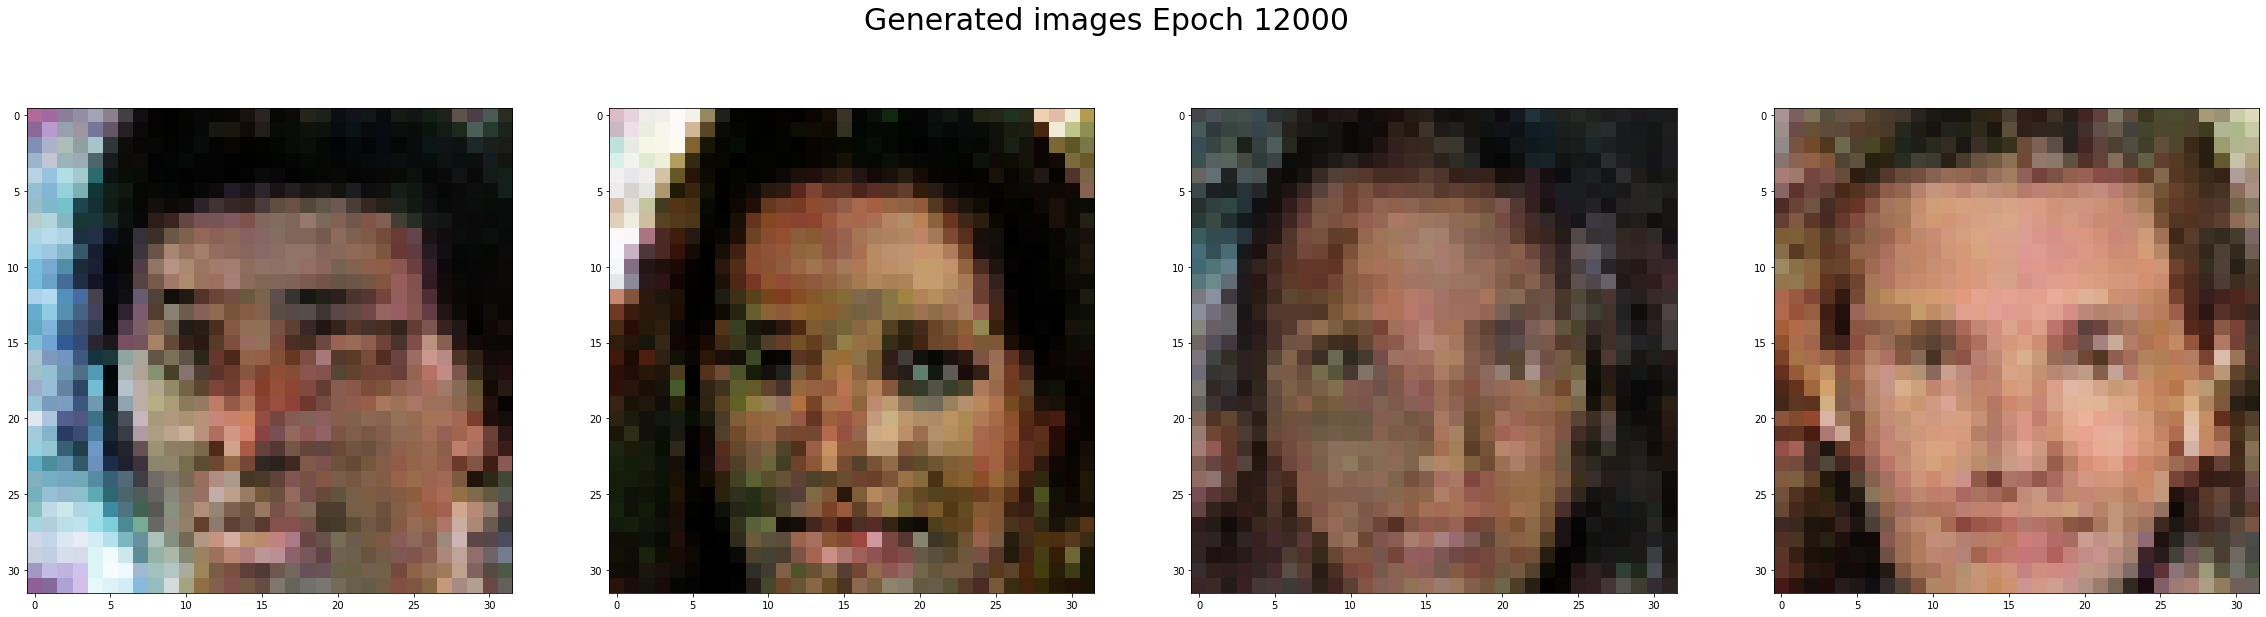

Epoch 12500 [D loss: 0.453, acc.: 077.0%] [G loss: 1.534]


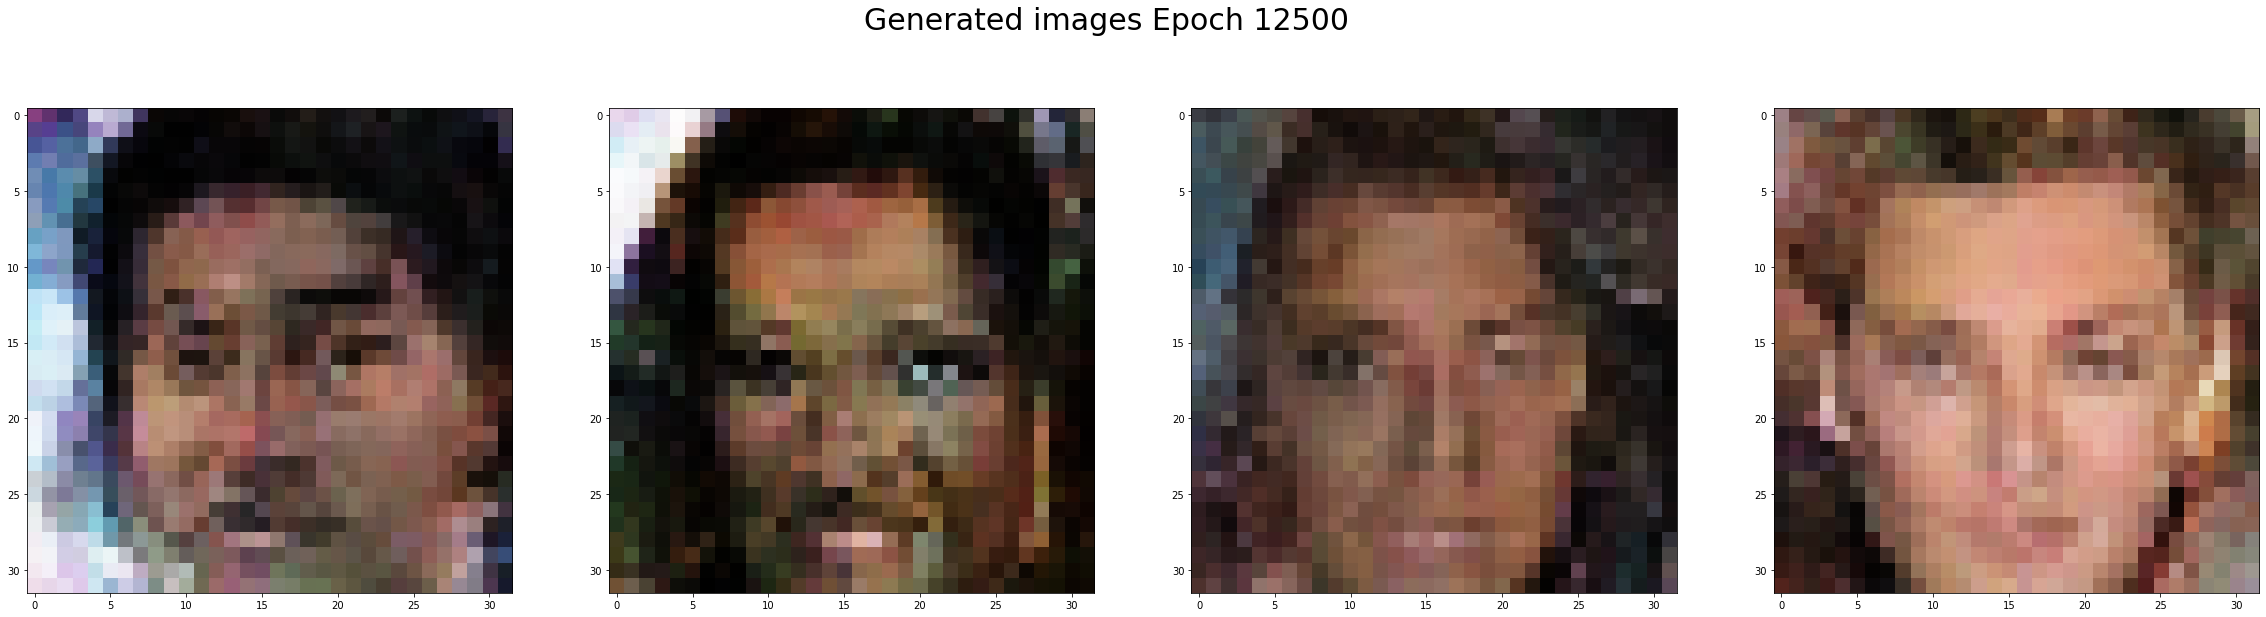

Epoch 13000 [D loss: 0.377, acc.: 085.5%] [G loss: 1.531]


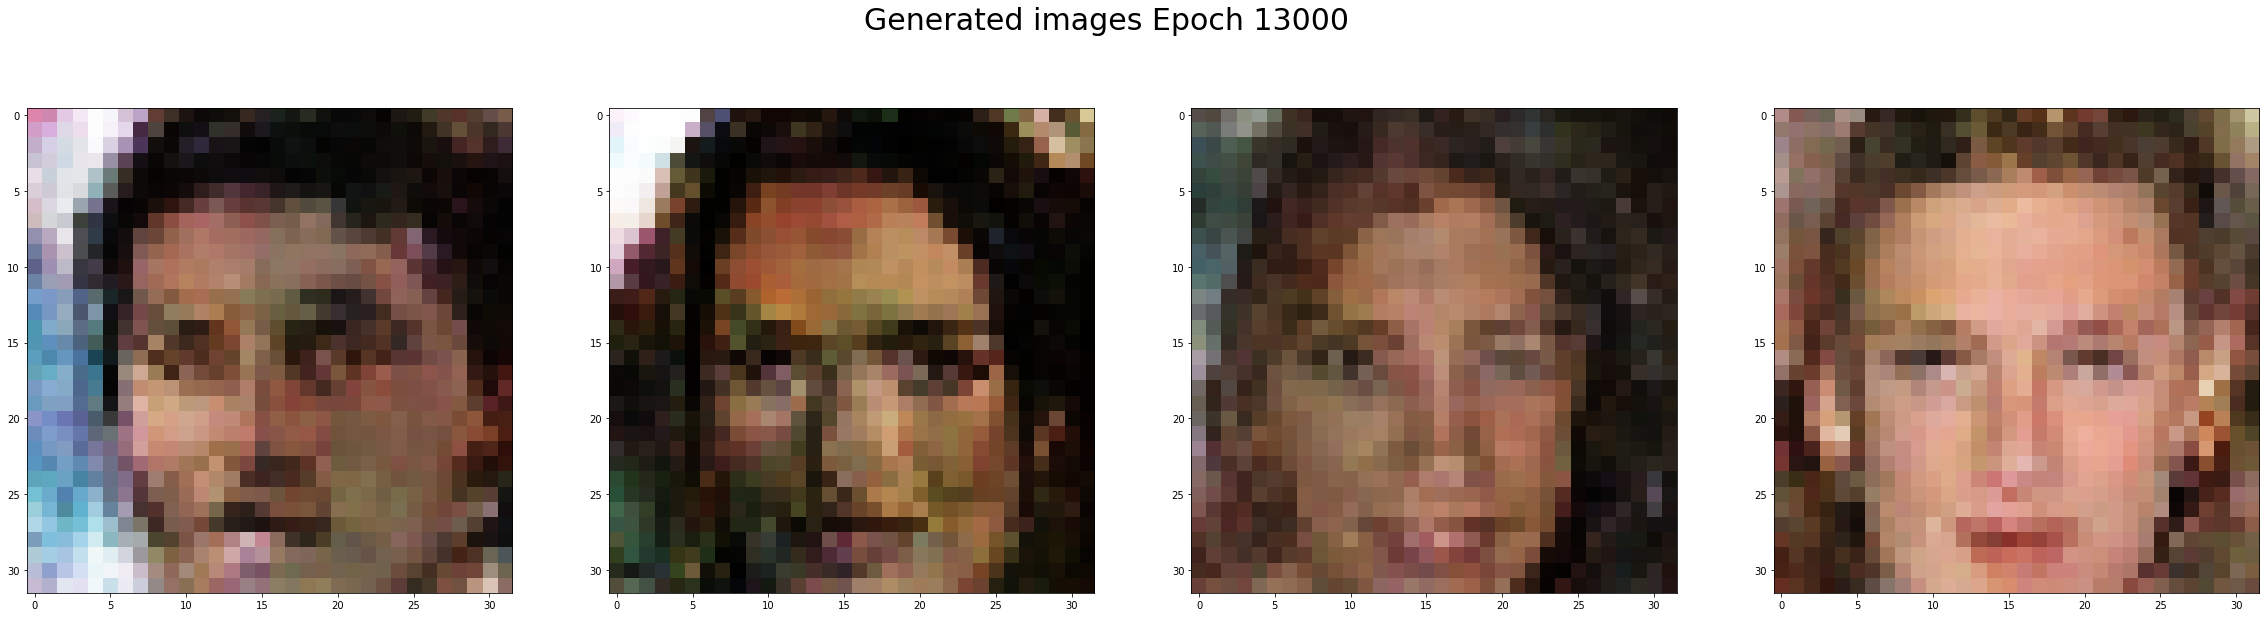

Epoch 13500 [D loss: 0.460, acc.: 077.7%] [G loss: 1.537]


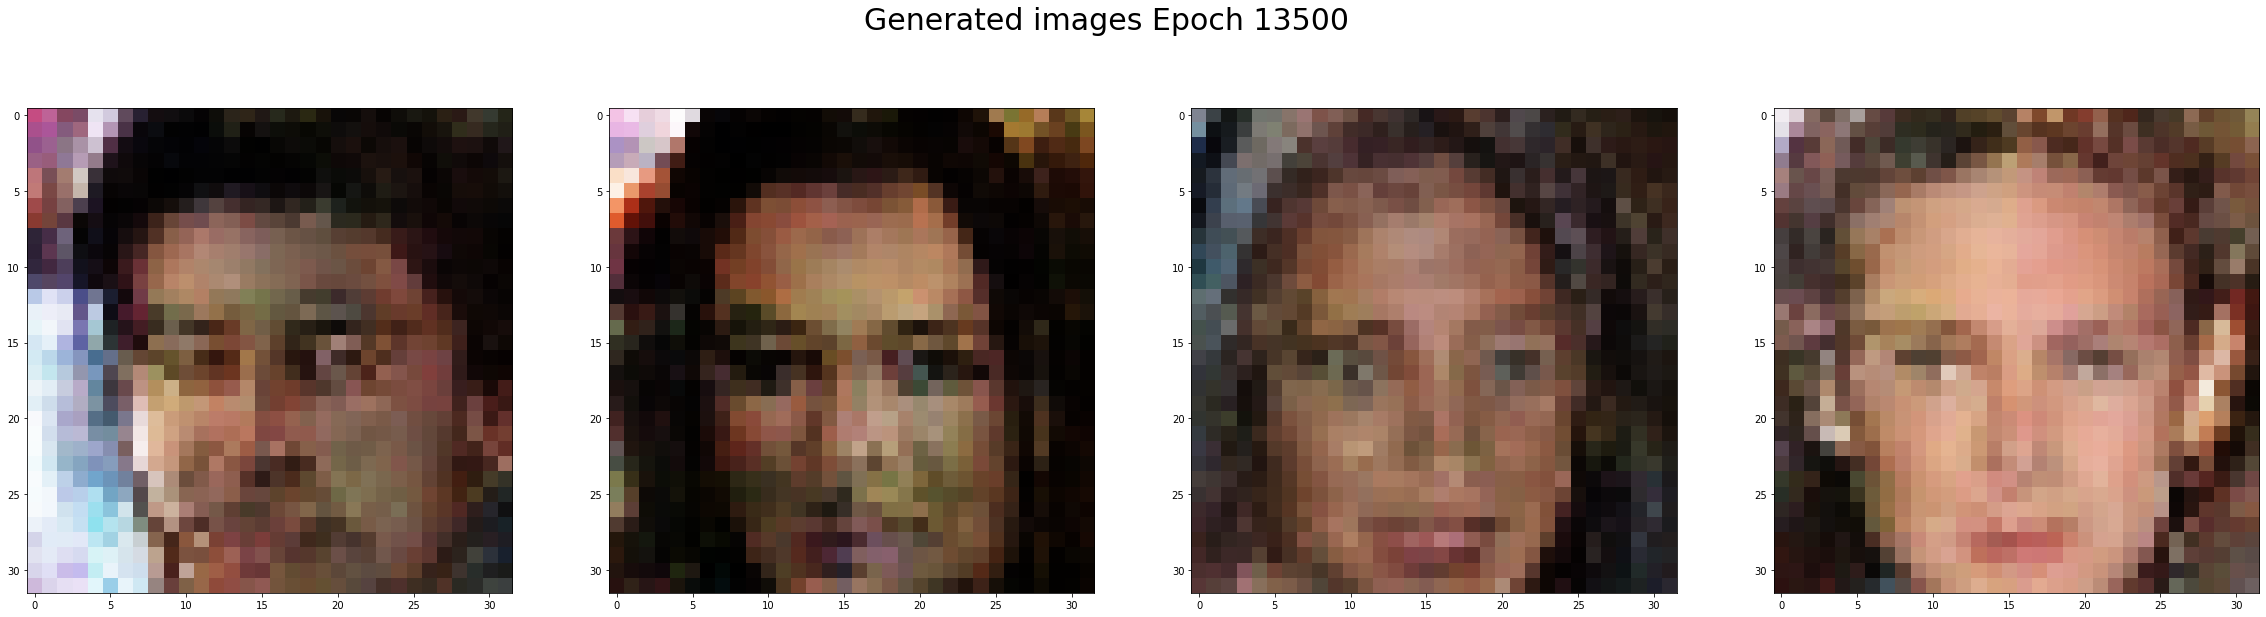

Epoch 14000 [D loss: 0.408, acc.: 082.0%] [G loss: 1.699]


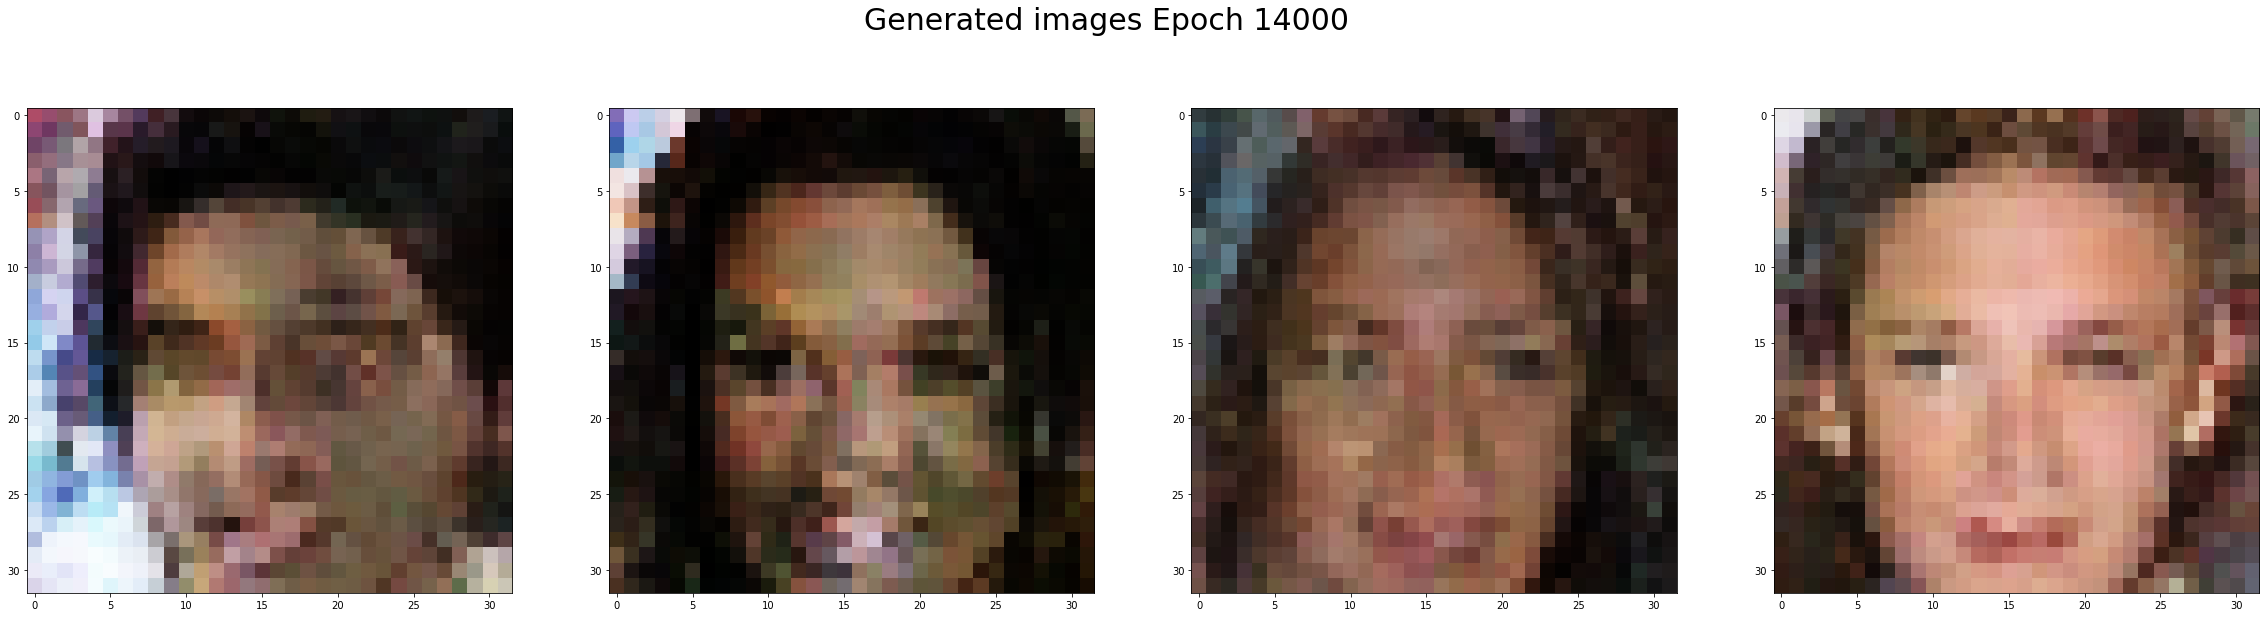

Epoch 14500 [D loss: 0.384, acc.: 083.2%] [G loss: 1.730]


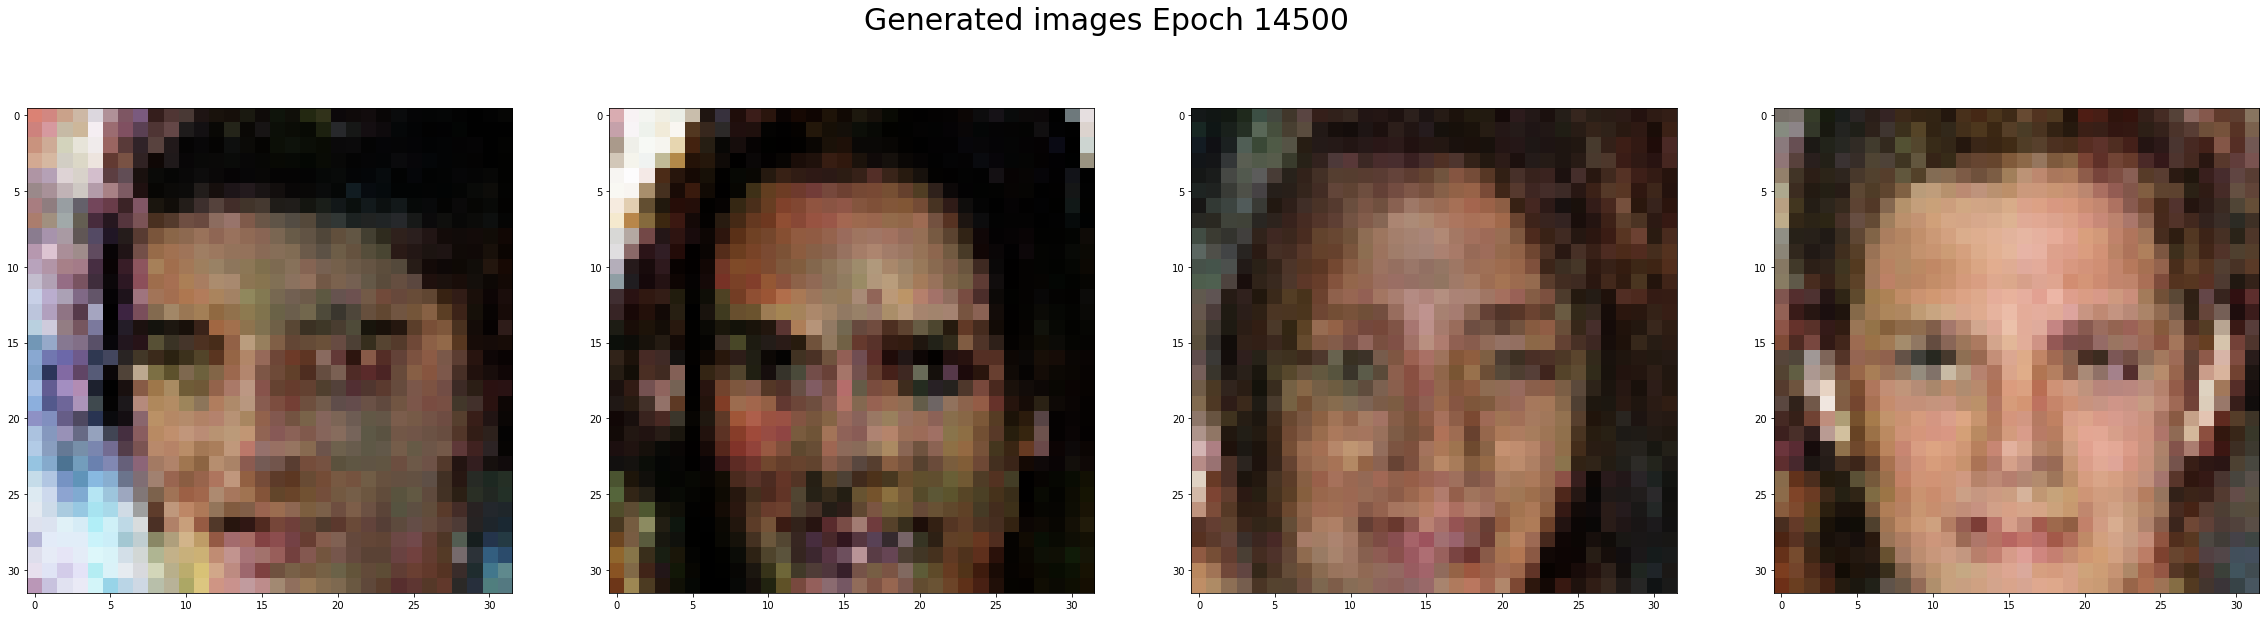

Epoch 15000 [D loss: 0.388, acc.: 081.6%] [G loss: 1.715]


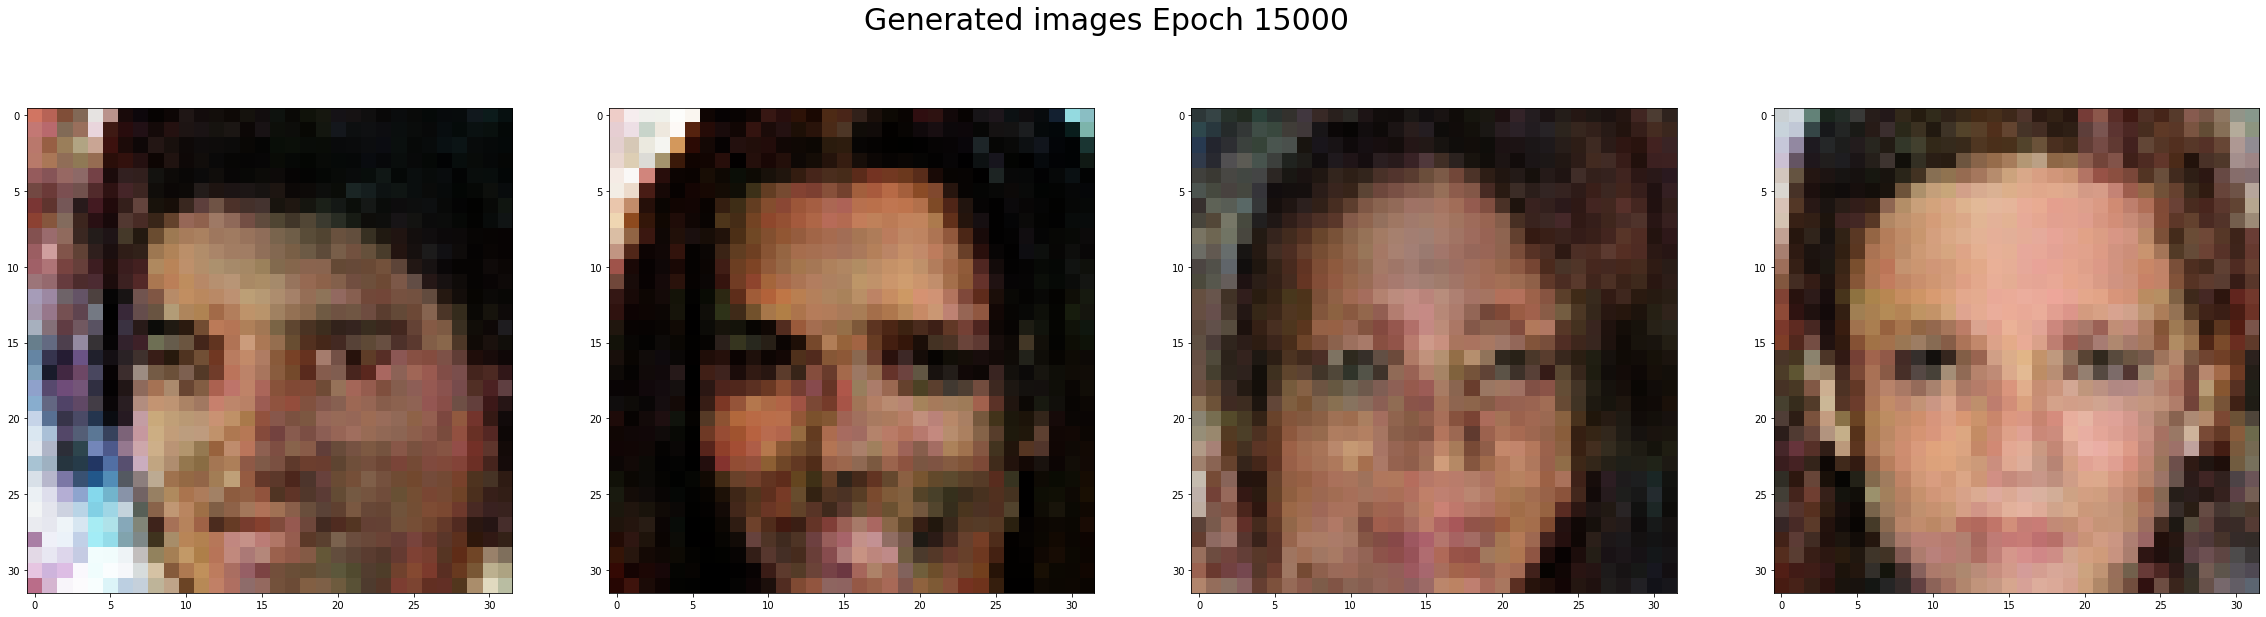

Epoch 15500 [D loss: 0.402, acc.: 082.0%] [G loss: 1.698]


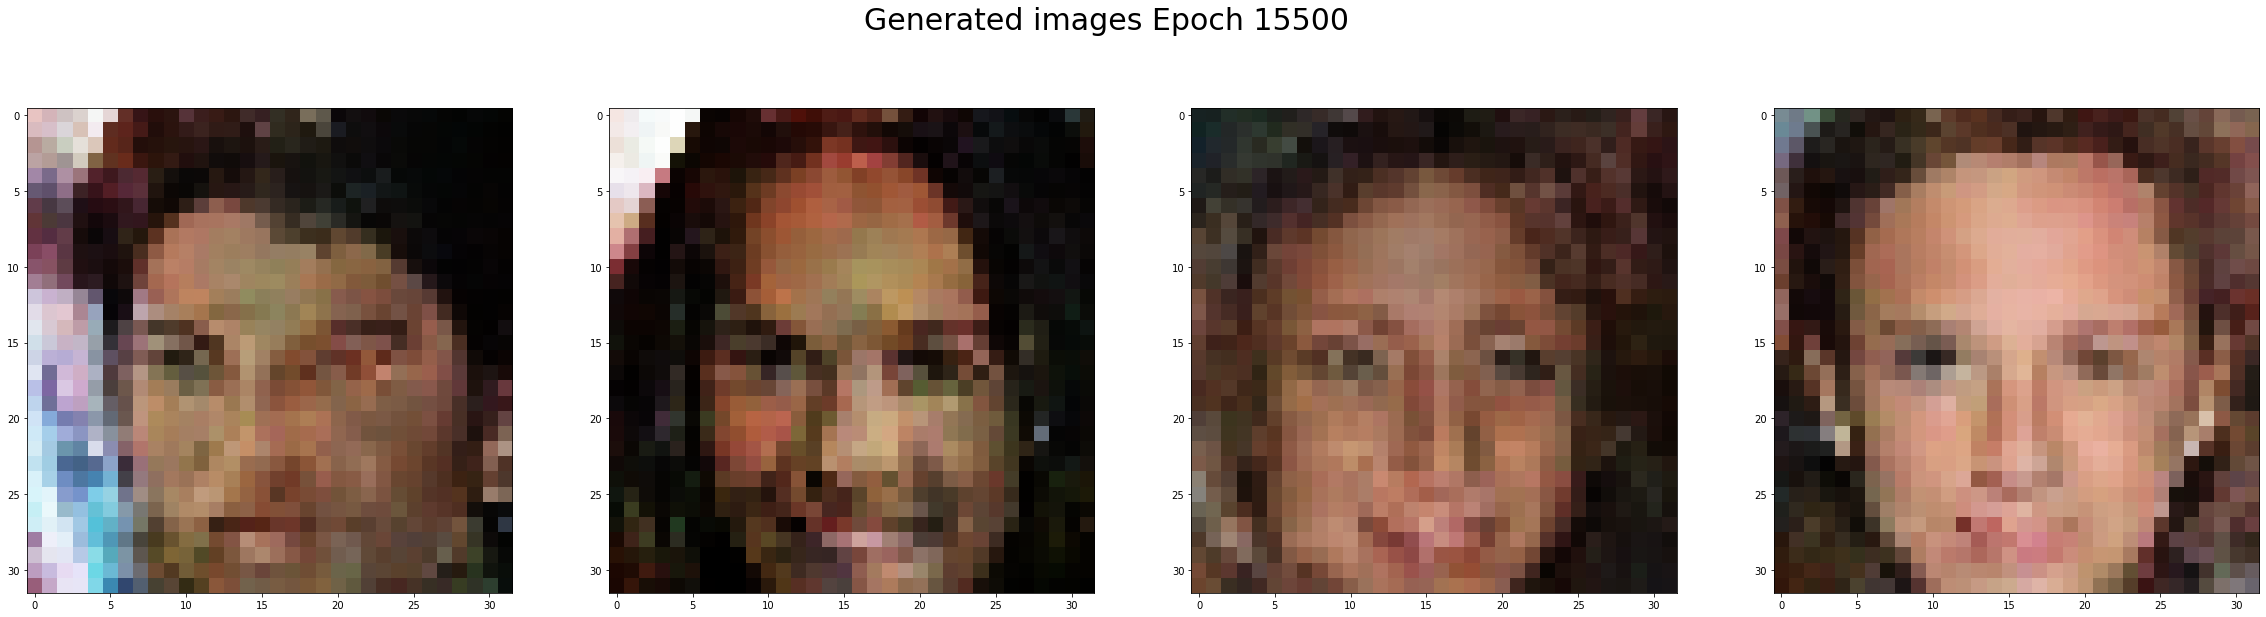

Epoch 16000 [D loss: 0.387, acc.: 082.0%] [G loss: 1.752]


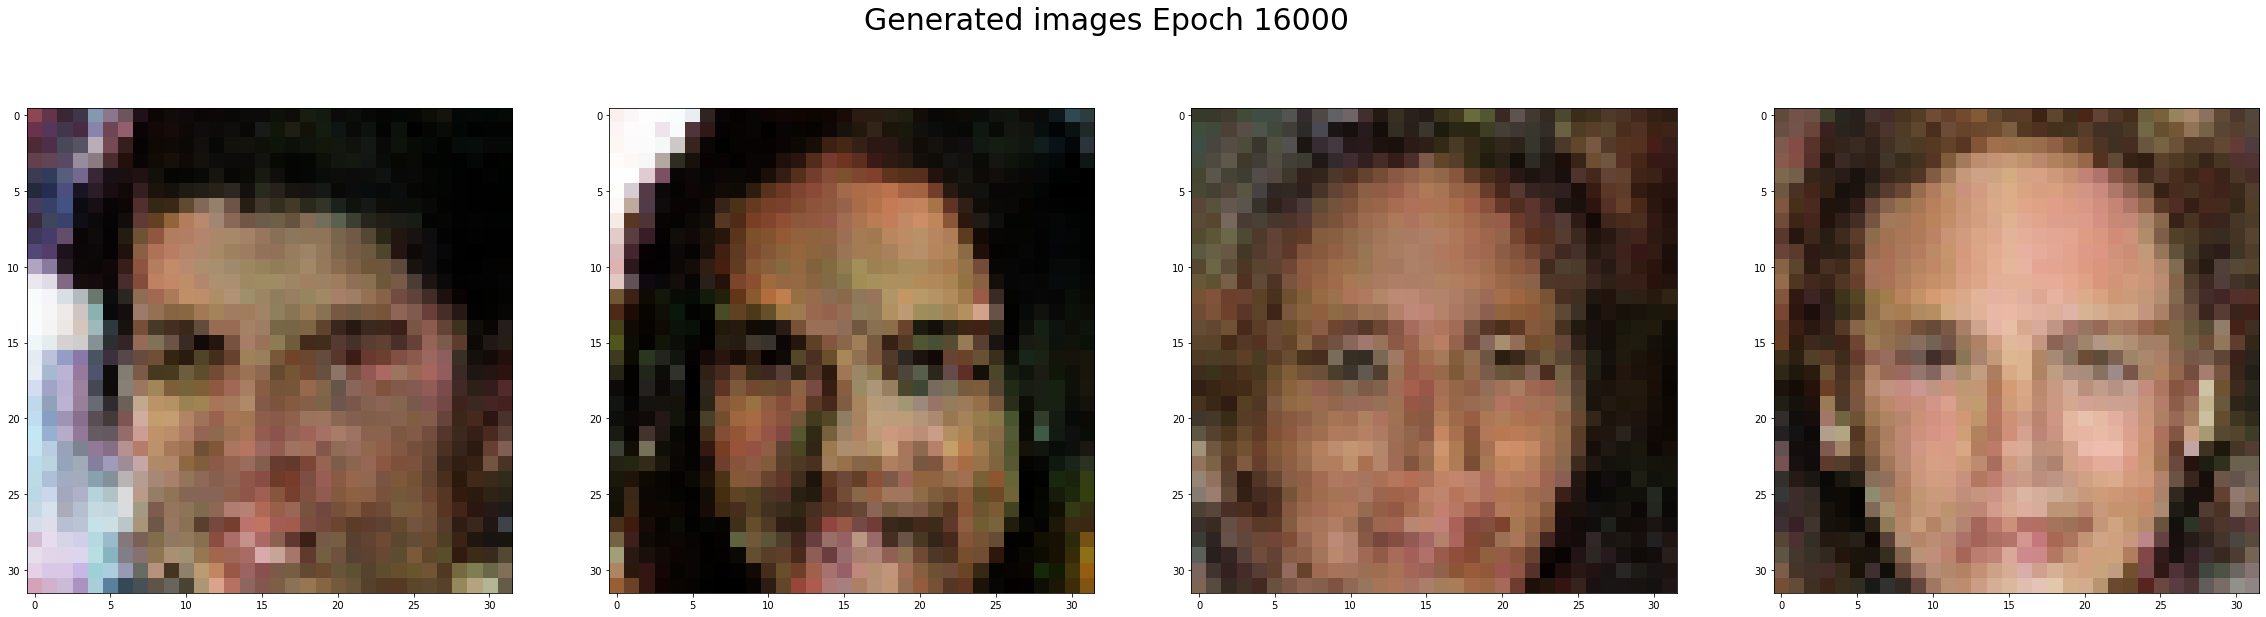

Epoch 16500 [D loss: 0.398, acc.: 081.6%] [G loss: 1.821]


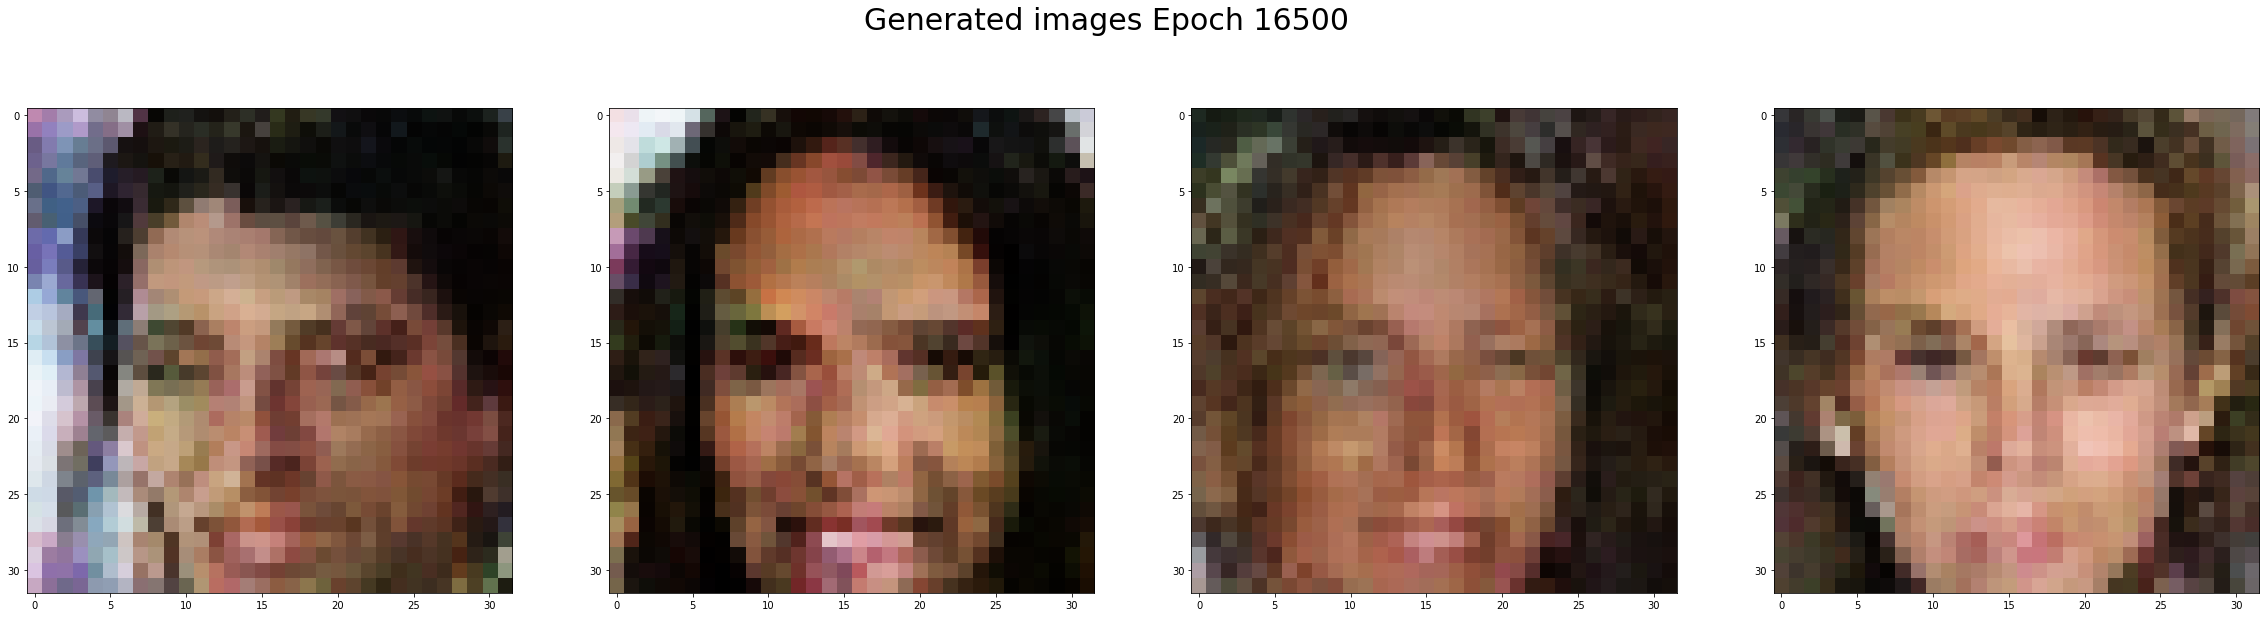

Epoch 17000 [D loss: 0.377, acc.: 083.2%] [G loss: 1.904]


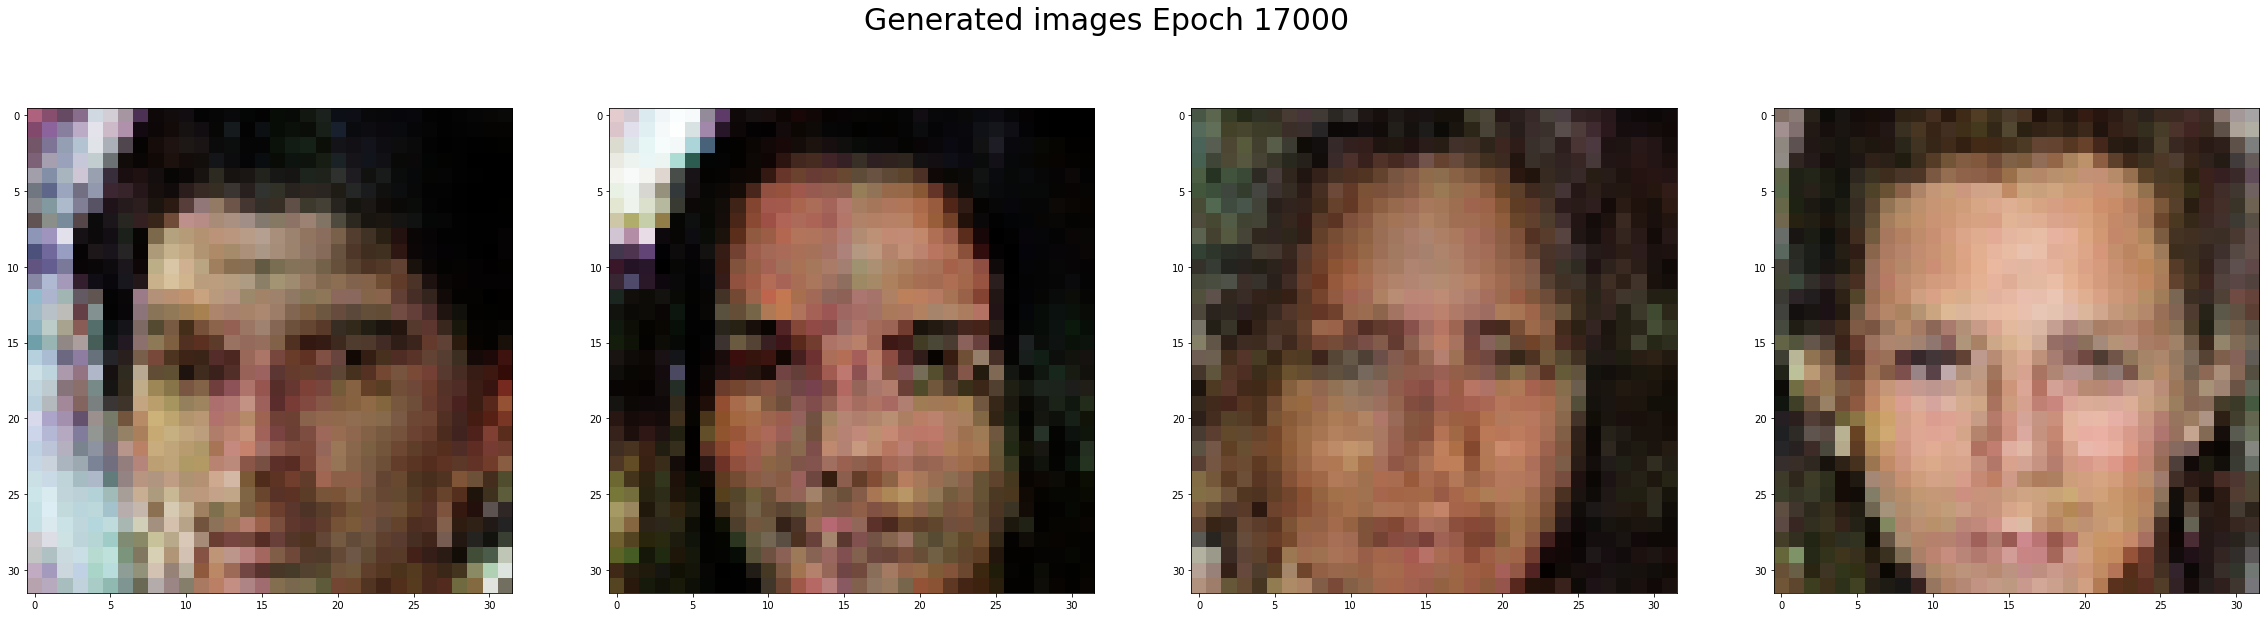

Epoch 17500 [D loss: 0.366, acc.: 085.2%] [G loss: 1.909]


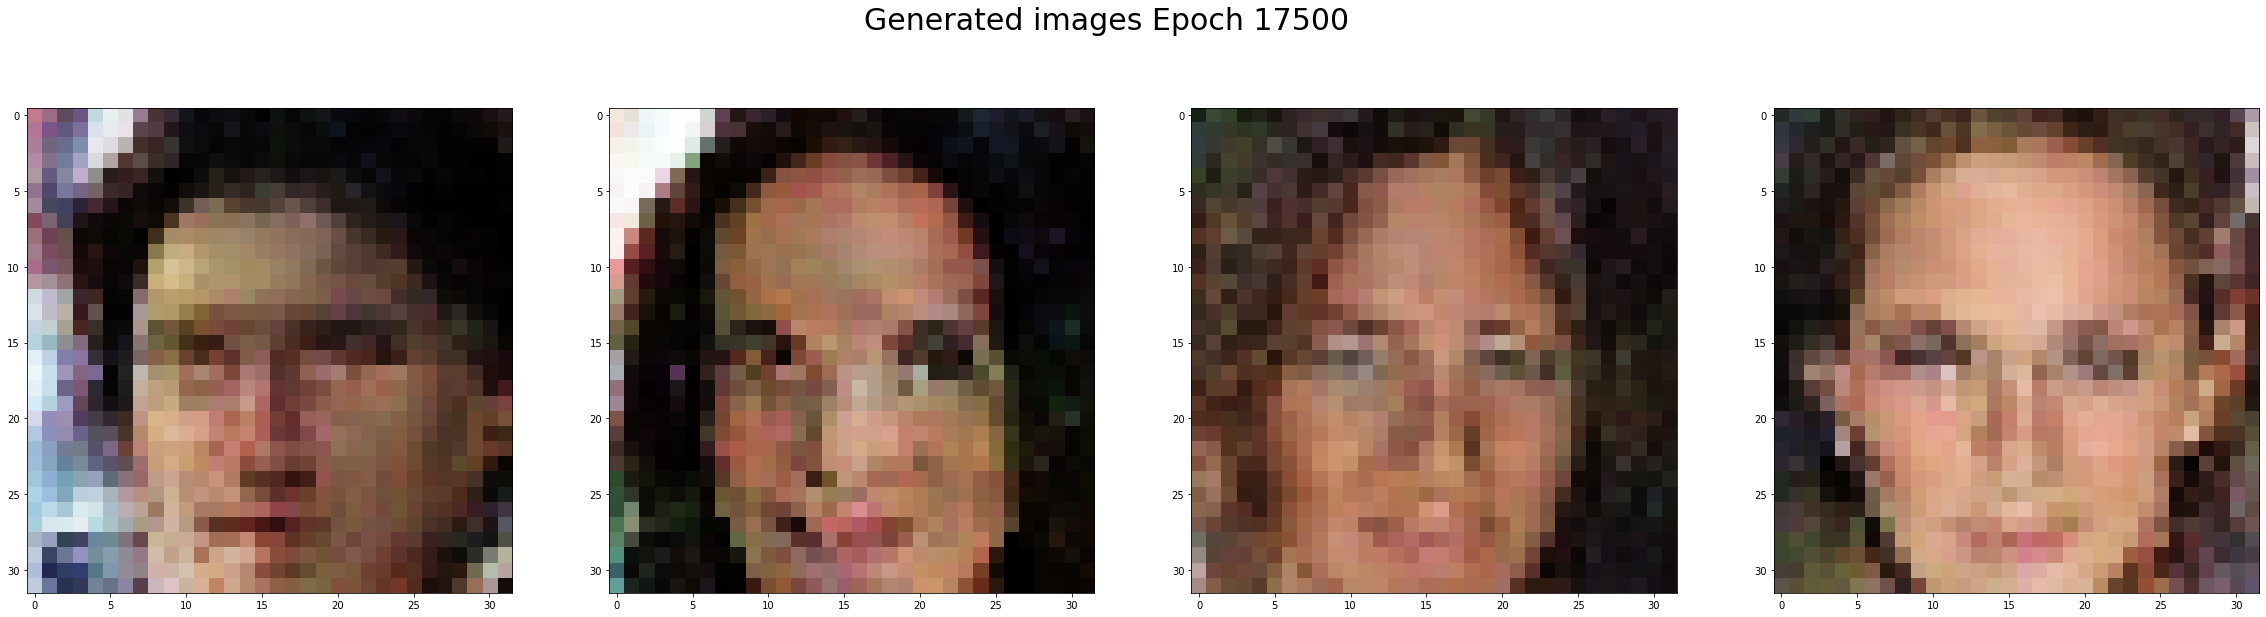

Epoch 18000 [D loss: 0.309, acc.: 087.9%] [G loss: 1.915]


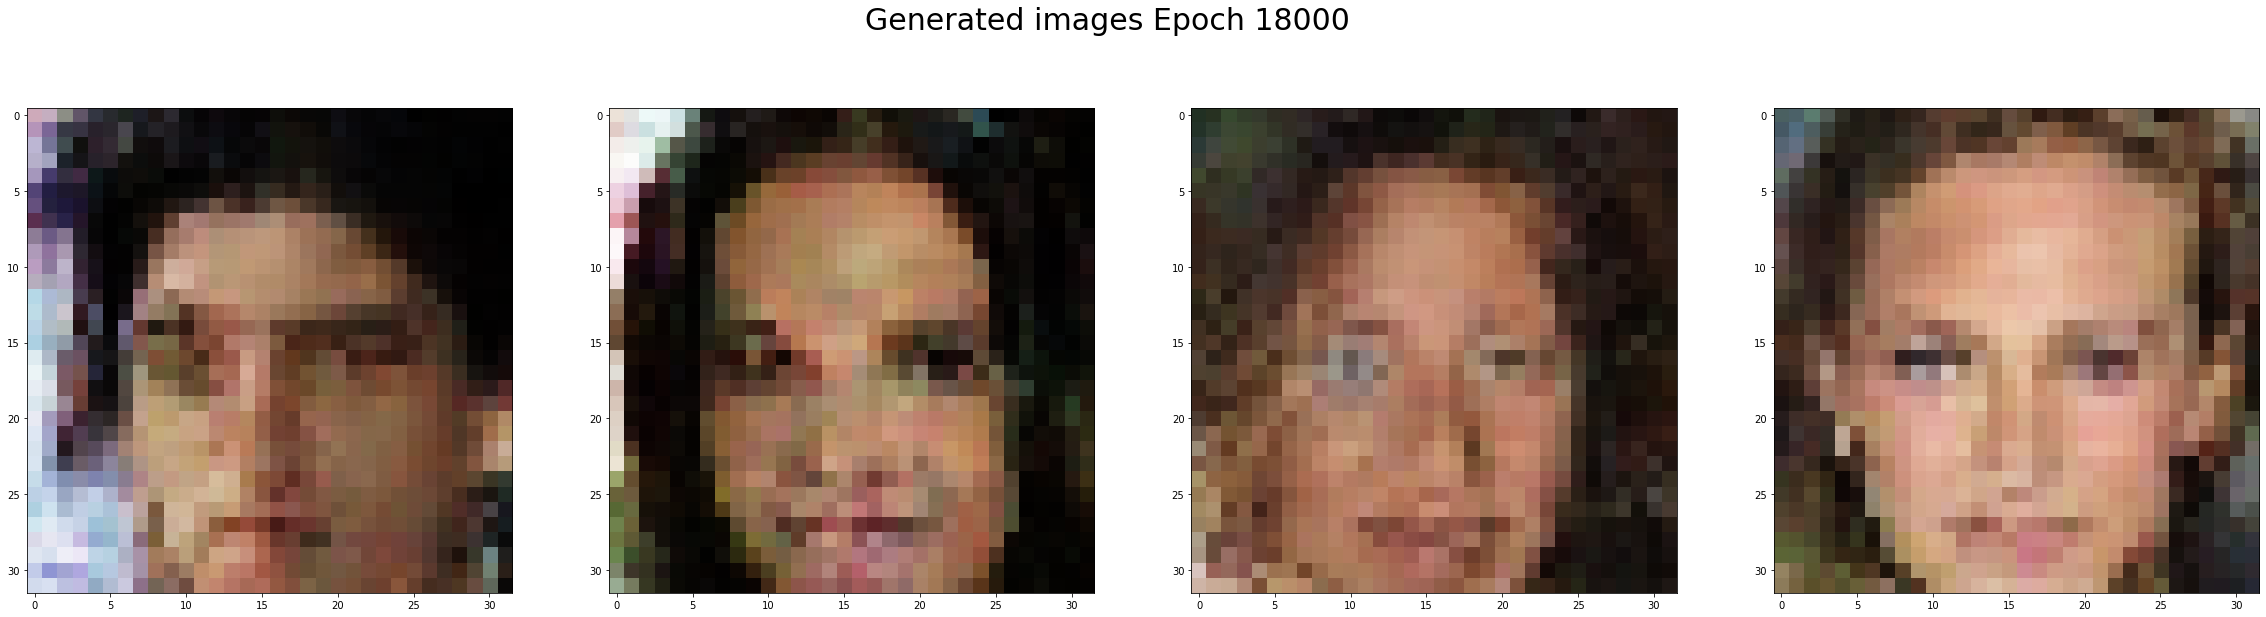

Epoch 18500 [D loss: 0.336, acc.: 085.2%] [G loss: 2.024]


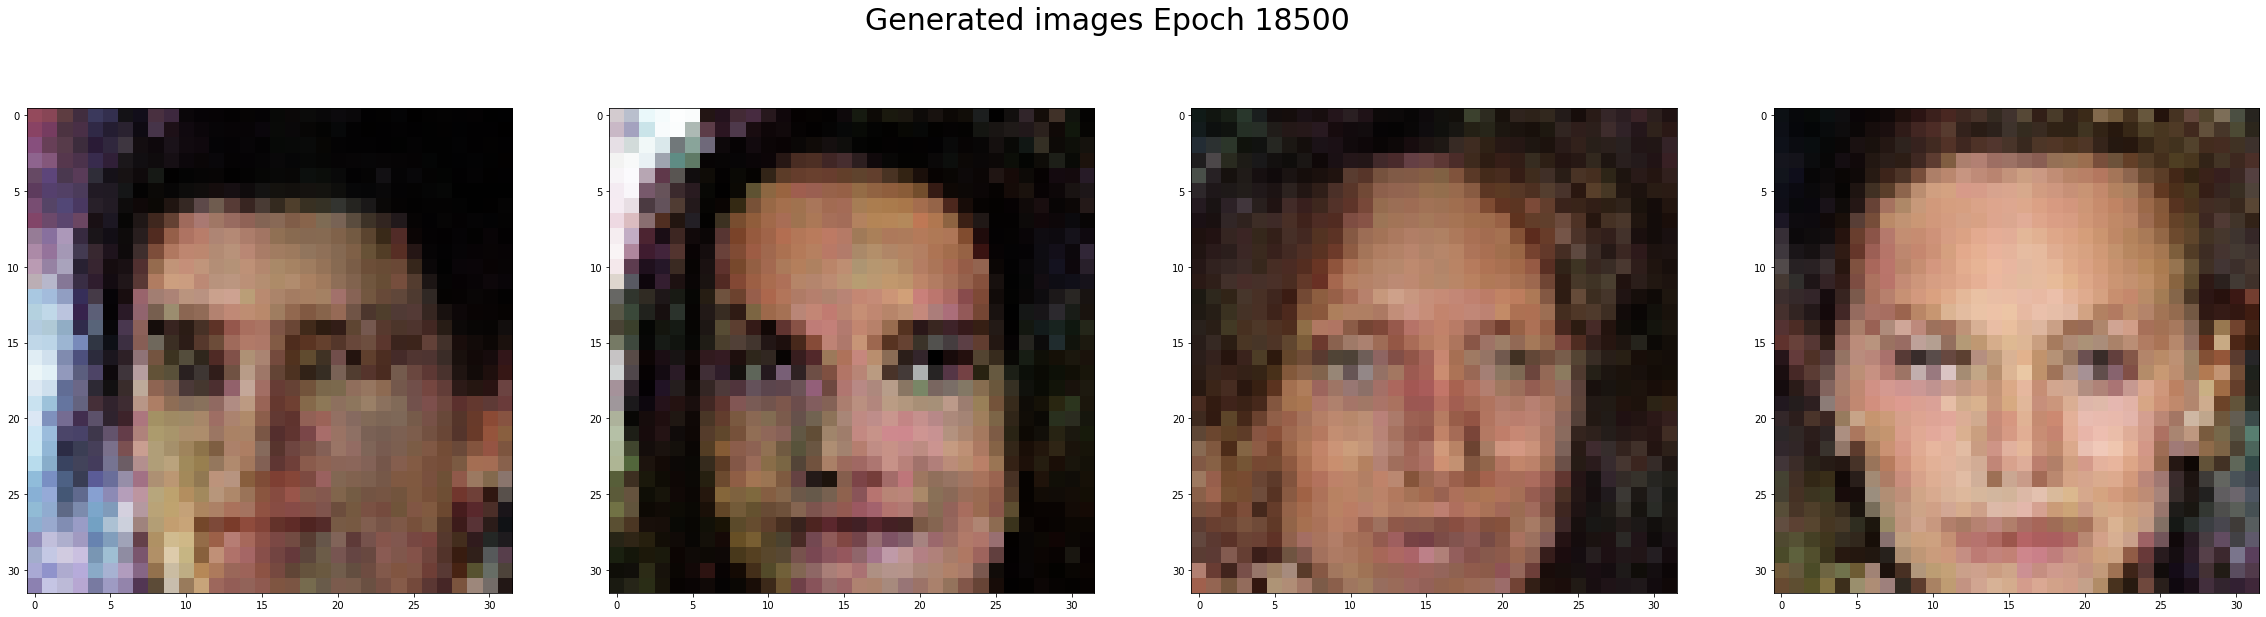

Epoch 19000 [D loss: 0.579, acc.: 071.5%] [G loss: 0.990]


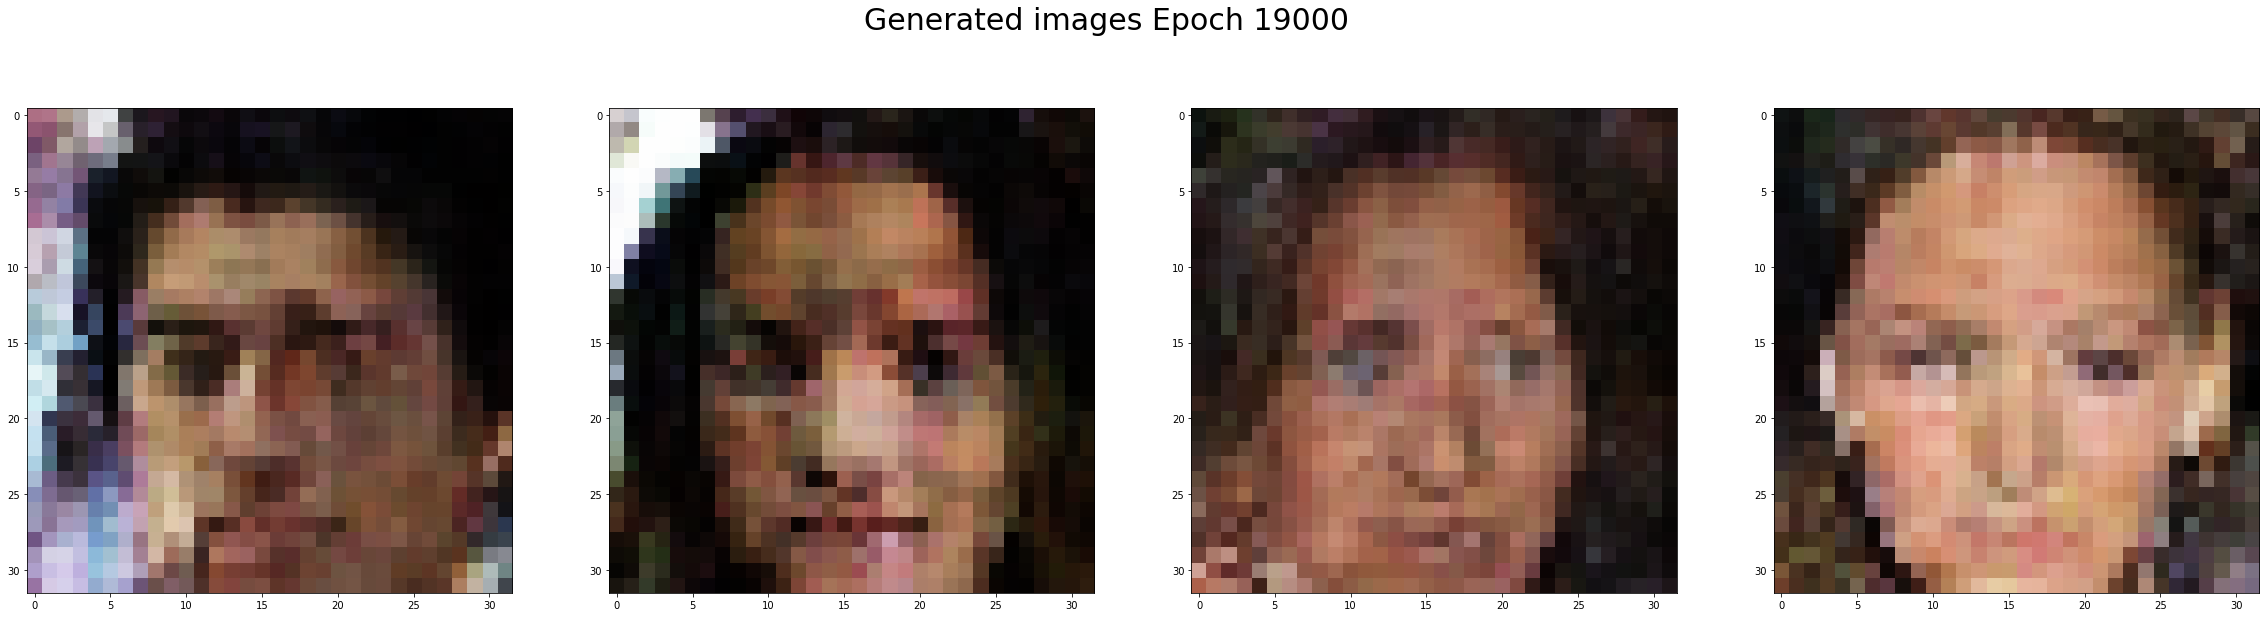

Epoch 19500 [D loss: 0.307, acc.: 089.5%] [G loss: 2.048]


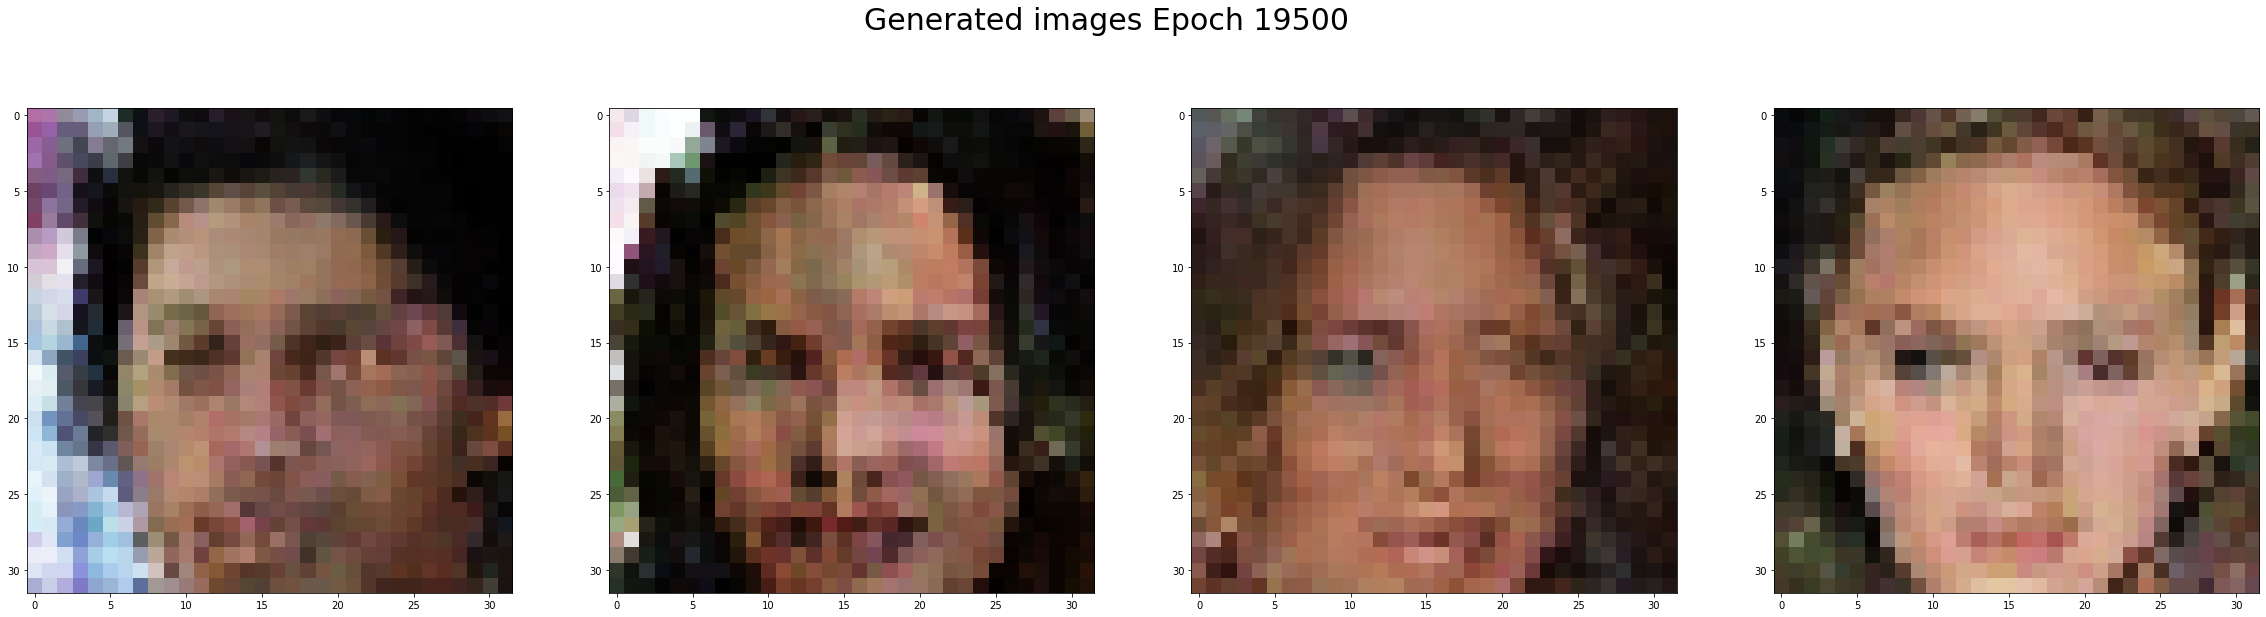

In [ ]:
def train(models, X_train, noise_plot, dir_result="/result/", epochs=10000, batch_size=64):
        '''
        models     : tuple containins three tensors, (combined, discriminator, generator)
        X_train    : np.array containing images (Nsample, height, width, Nchannels)
        noise_plot : np.array of size (Nrandom_sample_to_plot, hidden unit length)
        dir_result : the location where the generated plots for noise_plot are saved 
        
        '''
        combined, discriminator, generator = models
        nlatent_dim = noise_plot.shape[1]
        half_batch  = int(batch_size / 2)
        history = []
        
        for epoch in range(epochs):

            # ---------------------
            #  Train Discriminator
            # ---------------------

            # Select a random half batch of images
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]
            noise = get_noise(half_batch, nlatent_dim)

            # Generate a half batch of new images
            gen_imgs = generator.predict(noise)

            # Train the discriminator q: better to mix them together?
            d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
            d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
            

            # ---------------------
            #  Train Generator
            # ---------------------

            noise = get_noise(batch_size, nlatent_dim)

            # The generator wants the discriminator to label the generated samples
            # as valid (ones)
            valid_y = (np.array([1] * batch_size)).reshape(batch_size,1)
            
            # Train the generator
            g_loss = combined.train_on_batch(noise, valid_y)

            history.append({"D":d_loss[0],"G":g_loss})
            
            if epoch % 500 == 0:
                # Plot the progress
                print ("Epoch {:05.0f} [D loss: {:4.3f}, acc.: {:05.1f}%] [G loss: {:4.3f}]".format(
                    epoch, d_loss[0], 100*d_loss[1], g_loss))
            if epoch % int(epochs/50) == 0:
                plot_generated_images(noise_plot,
                                      path_save=dir_result+"/image_{:05.0f}.png".format(epoch),
                                      titleadd="Epoch {}".format(epoch))
            if epoch % 500 == 0:
                plot_generated_images(noise_plot,
                                      titleadd="Epoch {}".format(epoch))
                        
        return(history)

dir_result="./result_GAN/"

try:
    os.mkdir(dir_result)
except:
    pass
    
start_time = time.time()

_models = combined, discriminator, generator          

history = train(_models, X_train, noise, dir_result=dir_result,
                epochs=35000, batch_size=256)

end_time = time.time()
print("-"*10)
print("Time took: {:4.2f} min".format((end_time - start_time)/60))

In [ ]:
import pandas as pd 

hist = pd.DataFrame(history)

plt.figure(figsize=(20,5))

for colnm in hist.columns:
    plt.plot(hist[colnm],label=colnm)
plt.legend()
plt.ylabel("loss")
plt.xlabel("epochs")
plt.show()

In [6]:
dir_result="./result_GAN/"

In [7]:
def makegif(dir_images):
    
    import imageio
    
    filenames = np.sort(os.listdir(dir_images))
    
    filenames = [fnm for fnm in filenames if ".png" in fnm]

    with imageio.get_writer(dir_images + '/image.gif', mode='I') as writer:
        
        for filename in filenames:
            
            image = imageio.imread(dir_images + filename)
            writer.append_data(image)
            os.remove(dir_images + filename)
            
makegif(dir_result)